##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [2]:
!pip install -q tensorflow==2.3.1

Install TensorFlow Quantum:

In [3]:
!pip install -q tensorflow-quantum

Now import TensorFlow and the module dependencies:

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

 9789440/11490434 [========================>.....] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [6]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [7]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


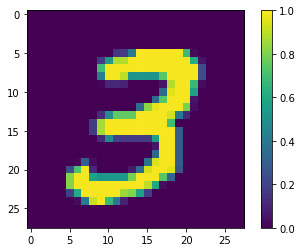

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [9]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


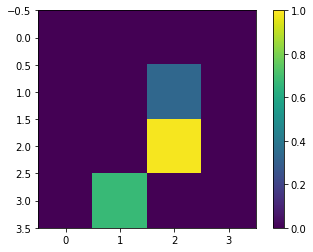

In [10]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [11]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [12]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [13]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [14]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [15]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


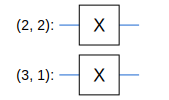

In [16]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [17]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [18]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [19]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

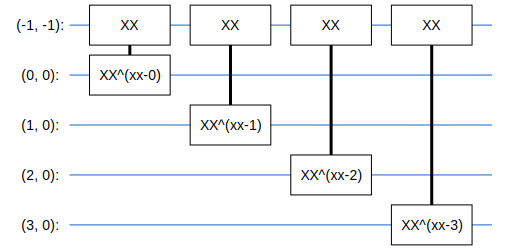

In [20]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [21]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [22]:
model_circuit, model_readout = create_quantum_model()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [23]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [24]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [25]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [26]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [27]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [28]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [29]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [30]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3


  1/324 [..............................] - ETA: 0s - loss: 1.0047 - hinge_accuracy: 0.3750

  2/324 [..............................] - ETA: 27s - loss: 1.0032 - hinge_accuracy: 0.4062

  3/324 [..............................] - ETA: 36s - loss: 1.0022 - hinge_accuracy: 0.4271

  4/324 [..............................] - ETA: 41s - loss: 1.0012 - hinge_accuracy: 0.4609

  5/324 [..............................] - ETA: 43s - loss: 1.0002 - hinge_accuracy: 0.4812

  6/324 [..............................] - ETA: 45s - loss: 0.9997 - hinge_accuracy: 0.4740

  7/324 [..............................] - ETA: 46s - loss: 0.9996 - hinge_accuracy: 0.4688

  8/324 [..............................] - ETA: 47s - loss: 1.0000 - hinge_accuracy: 0.4570

  9/324 [..............................] - ETA: 48s - loss: 0.9995 - hinge_accuracy: 0.4618

 10/324 [..............................] - ETA: 48s - loss: 0.9988 - hinge_accuracy: 0.4719

 11/324 [>.............................] - ETA: 49s - loss: 0.9980 - hinge_accuracy: 0.4858

 12/324 [>.............................] - ETA: 49s - loss: 0.9979 - hinge_accuracy: 0.4948

 13/324 [>.............................] - ETA: 49s - loss: 0.9974 - hinge_accuracy: 0.5120

 14/324 [>.............................] - ETA: 49s - loss: 0.9970 - hinge_accuracy: 0.5223

 15/324 [>.............................] - ETA: 49s - loss: 0.9968 - hinge_accuracy: 0.5312

 16/324 [>.............................] - ETA: 49s - loss: 0.9965 - hinge_accuracy: 0.5430

 17/324 [>.............................] - ETA: 49s - loss: 0.9965 - hinge_accuracy: 0.5441

 18/324 [>.............................] - ETA: 49s - loss: 0.9960 - hinge_accuracy: 0.5590

 19/324 [>.............................] - ETA: 49s - loss: 0.9960 - hinge_accuracy: 0.5559

 20/324 [>.............................] - ETA: 49s - loss: 0.9959 - hinge_accuracy: 0.5594

 21/324 [>.............................] - ETA: 49s - loss: 0.9956 - hinge_accuracy: 0.5670

 22/324 [=>............................] - ETA: 49s - loss: 0.9951 - hinge_accuracy: 0.5753

 23/324 [=>............................] - ETA: 49s - loss: 0.9948 - hinge_accuracy: 0.5788

 24/324 [=>............................] - ETA: 48s - loss: 0.9947 - hinge_accuracy: 0.5794

 25/324 [=>............................] - ETA: 48s - loss: 0.9945 - hinge_accuracy: 0.5850

 26/324 [=>............................] - ETA: 48s - loss: 0.9947 - hinge_accuracy: 0.5829

 27/324 [=>............................] - ETA: 48s - loss: 0.9945 - hinge_accuracy: 0.5880

 28/324 [=>............................] - ETA: 48s - loss: 0.9940 - hinge_accuracy: 0.5949

 29/324 [=>............................] - ETA: 48s - loss: 0.9937 - hinge_accuracy: 0.6013

 30/324 [=>............................] - ETA: 48s - loss: 0.9934 - hinge_accuracy: 0.6031

 31/324 [=>............................] - ETA: 48s - loss: 0.9931 - hinge_accuracy: 0.6099

 32/324 [=>............................] - ETA: 48s - loss: 0.9927 - hinge_accuracy: 0.6133

 33/324 [==>...........................] - ETA: 48s - loss: 0.9924 - hinge_accuracy: 0.6165

 34/324 [==>...........................] - ETA: 47s - loss: 0.9920 - hinge_accuracy: 0.6222

 35/324 [==>...........................] - ETA: 47s - loss: 0.9916 - hinge_accuracy: 0.6277

 36/324 [==>...........................] - ETA: 47s - loss: 0.9913 - hinge_accuracy: 0.6302

 37/324 [==>...........................] - ETA: 47s - loss: 0.9909 - hinge_accuracy: 0.6334

 38/324 [==>...........................] - ETA: 47s - loss: 0.9903 - hinge_accuracy: 0.6406

 39/324 [==>...........................] - ETA: 47s - loss: 0.9899 - hinge_accuracy: 0.6434

 40/324 [==>...........................] - ETA: 47s - loss: 0.9895 - hinge_accuracy: 0.6469

 41/324 [==>...........................] - ETA: 46s - loss: 0.9893 - hinge_accuracy: 0.6479

 42/324 [==>...........................] - ETA: 46s - loss: 0.9888 - hinge_accuracy: 0.6503

 43/324 [==>...........................] - ETA: 46s - loss: 0.9880 - hinge_accuracy: 0.6555

 44/324 [===>..........................] - ETA: 46s - loss: 0.9875 - hinge_accuracy: 0.6591

 45/324 [===>..........................] - ETA: 46s - loss: 0.9870 - hinge_accuracy: 0.6611

 46/324 [===>..........................] - ETA: 46s - loss: 0.9863 - hinge_accuracy: 0.6658

 47/324 [===>..........................] - ETA: 46s - loss: 0.9859 - hinge_accuracy: 0.6662

 48/324 [===>..........................] - ETA: 45s - loss: 0.9854 - hinge_accuracy: 0.6686

 49/324 [===>..........................] - ETA: 45s - loss: 0.9849 - hinge_accuracy: 0.6716

 50/324 [===>..........................] - ETA: 45s - loss: 0.9845 - hinge_accuracy: 0.6731

 51/324 [===>..........................] - ETA: 45s - loss: 0.9840 - hinge_accuracy: 0.6752

 52/324 [===>..........................] - ETA: 45s - loss: 0.9835 - hinge_accuracy: 0.6773

 53/324 [===>..........................] - ETA: 45s - loss: 0.9830 - hinge_accuracy: 0.6787

 54/324 [====>.........................] - ETA: 44s - loss: 0.9824 - hinge_accuracy: 0.6817

 55/324 [====>.........................] - ETA: 44s - loss: 0.9819 - hinge_accuracy: 0.6835

 56/324 [====>.........................] - ETA: 44s - loss: 0.9814 - hinge_accuracy: 0.6842

 57/324 [====>.........................] - ETA: 44s - loss: 0.9809 - hinge_accuracy: 0.6859

 58/324 [====>.........................] - ETA: 44s - loss: 0.9803 - hinge_accuracy: 0.6875

 59/324 [====>.........................] - ETA: 44s - loss: 0.9796 - hinge_accuracy: 0.6896

 60/324 [====>.........................] - ETA: 43s - loss: 0.9791 - hinge_accuracy: 0.6917

 61/324 [====>.........................] - ETA: 43s - loss: 0.9783 - hinge_accuracy: 0.6942

 62/324 [====>.........................] - ETA: 43s - loss: 0.9777 - hinge_accuracy: 0.6956

 63/324 [====>.........................] - ETA: 43s - loss: 0.9769 - hinge_accuracy: 0.6974

 64/324 [====>.........................] - ETA: 43s - loss: 0.9764 - hinge_accuracy: 0.6978

 65/324 [=====>........................] - ETA: 43s - loss: 0.9759 - hinge_accuracy: 0.6981

 66/324 [=====>........................] - ETA: 43s - loss: 0.9752 - hinge_accuracy: 0.6993

 67/324 [=====>........................] - ETA: 42s - loss: 0.9741 - hinge_accuracy: 0.7020

 68/324 [=====>........................] - ETA: 42s - loss: 0.9737 - hinge_accuracy: 0.7017

 69/324 [=====>........................] - ETA: 42s - loss: 0.9734 - hinge_accuracy: 0.7011

 70/324 [=====>........................] - ETA: 42s - loss: 0.9734 - hinge_accuracy: 0.6996

 71/324 [=====>........................] - ETA: 42s - loss: 0.9727 - hinge_accuracy: 0.7007

 72/324 [=====>........................] - ETA: 42s - loss: 0.9718 - hinge_accuracy: 0.7010

 73/324 [=====>........................] - ETA: 41s - loss: 0.9712 - hinge_accuracy: 0.7021

 74/324 [=====>........................] - ETA: 41s - loss: 0.9705 - hinge_accuracy: 0.7031

 75/324 [=====>........................] - ETA: 41s - loss: 0.9694 - hinge_accuracy: 0.7046

 76/324 [======>.......................] - ETA: 41s - loss: 0.9688 - hinge_accuracy: 0.7052

 77/324 [======>.......................] - ETA: 41s - loss: 0.9687 - hinge_accuracy: 0.7041

 78/324 [======>.......................] - ETA: 41s - loss: 0.9677 - hinge_accuracy: 0.7059

 79/324 [======>.......................] - ETA: 41s - loss: 0.9668 - hinge_accuracy: 0.7073

 80/324 [======>.......................] - ETA: 40s - loss: 0.9660 - hinge_accuracy: 0.7086

 81/324 [======>.......................] - ETA: 40s - loss: 0.9652 - hinge_accuracy: 0.7099

 82/324 [======>.......................] - ETA: 40s - loss: 0.9640 - hinge_accuracy: 0.7123

 83/324 [======>.......................] - ETA: 40s - loss: 0.9633 - hinge_accuracy: 0.7127

 84/324 [======>.......................] - ETA: 40s - loss: 0.9621 - hinge_accuracy: 0.7139

 85/324 [======>.......................] - ETA: 40s - loss: 0.9613 - hinge_accuracy: 0.7151

 86/324 [======>.......................] - ETA: 39s - loss: 0.9601 - hinge_accuracy: 0.7166

 87/324 [=======>......................] - ETA: 39s - loss: 0.9590 - hinge_accuracy: 0.7177

 88/324 [=======>......................] - ETA: 39s - loss: 0.9580 - hinge_accuracy: 0.7191

 89/324 [=======>......................] - ETA: 39s - loss: 0.9569 - hinge_accuracy: 0.7205

 90/324 [=======>......................] - ETA: 39s - loss: 0.9558 - hinge_accuracy: 0.7219

 91/324 [=======>......................] - ETA: 39s - loss: 0.9555 - hinge_accuracy: 0.7212

 92/324 [=======>......................] - ETA: 38s - loss: 0.9538 - hinge_accuracy: 0.7232

 93/324 [=======>......................] - ETA: 38s - loss: 0.9522 - hinge_accuracy: 0.7248

 94/324 [=======>......................] - ETA: 38s - loss: 0.9508 - hinge_accuracy: 0.7264

 95/324 [=======>......................] - ETA: 38s - loss: 0.9495 - hinge_accuracy: 0.7276

 96/324 [=======>......................] - ETA: 38s - loss: 0.9488 - hinge_accuracy: 0.7275

 97/324 [=======>......................] - ETA: 38s - loss: 0.9476 - hinge_accuracy: 0.7284

 98/324 [========>.....................] - ETA: 37s - loss: 0.9465 - hinge_accuracy: 0.7290

 99/324 [========>.....................] - ETA: 37s - loss: 0.9455 - hinge_accuracy: 0.7289

100/324 [========>.....................] - ETA: 37s - loss: 0.9447 - hinge_accuracy: 0.7291

101/324 [========>.....................] - ETA: 37s - loss: 0.9444 - hinge_accuracy: 0.7283

102/324 [========>.....................] - ETA: 37s - loss: 0.9432 - hinge_accuracy: 0.7289

103/324 [========>.....................] - ETA: 37s - loss: 0.9416 - hinge_accuracy: 0.7300

104/324 [========>.....................] - ETA: 36s - loss: 0.9407 - hinge_accuracy: 0.7302

105/324 [========>.....................] - ETA: 36s - loss: 0.9390 - hinge_accuracy: 0.7312

106/324 [========>.....................] - ETA: 36s - loss: 0.9371 - hinge_accuracy: 0.7329

107/324 [========>.....................] - ETA: 36s - loss: 0.9361 - hinge_accuracy: 0.7331

108/324 [=========>....................] - ETA: 36s - loss: 0.9351 - hinge_accuracy: 0.7329

109/324 [=========>....................] - ETA: 36s - loss: 0.9340 - hinge_accuracy: 0.7334

110/324 [=========>....................] - ETA: 35s - loss: 0.9319 - hinge_accuracy: 0.7349

111/324 [=========>....................] - ETA: 35s - loss: 0.9308 - hinge_accuracy: 0.7354

112/324 [=========>....................] - ETA: 35s - loss: 0.9304 - hinge_accuracy: 0.7347

113/324 [=========>....................] - ETA: 35s - loss: 0.9287 - hinge_accuracy: 0.7356

114/324 [=========>....................] - ETA: 35s - loss: 0.9267 - hinge_accuracy: 0.7368

115/324 [=========>....................] - ETA: 35s - loss: 0.9253 - hinge_accuracy: 0.7372

116/324 [=========>....................] - ETA: 34s - loss: 0.9233 - hinge_accuracy: 0.7387

117/324 [=========>....................] - ETA: 34s - loss: 0.9220 - hinge_accuracy: 0.7390

118/324 [=========>....................] - ETA: 34s - loss: 0.9202 - hinge_accuracy: 0.7402

119/324 [==========>...................] - ETA: 34s - loss: 0.9193 - hinge_accuracy: 0.7400

120/324 [==========>...................] - ETA: 34s - loss: 0.9183 - hinge_accuracy: 0.7401

121/324 [==========>...................] - ETA: 34s - loss: 0.9171 - hinge_accuracy: 0.7404

122/324 [==========>...................] - ETA: 33s - loss: 0.9157 - hinge_accuracy: 0.7408

123/324 [==========>...................] - ETA: 33s - loss: 0.9142 - hinge_accuracy: 0.7411

124/324 [==========>...................] - ETA: 33s - loss: 0.9128 - hinge_accuracy: 0.7414

125/324 [==========>...................] - ETA: 33s - loss: 0.9124 - hinge_accuracy: 0.7408

126/324 [==========>...................] - ETA: 33s - loss: 0.9114 - hinge_accuracy: 0.7408

127/324 [==========>...................] - ETA: 33s - loss: 0.9096 - hinge_accuracy: 0.7416

128/324 [==========>...................] - ETA: 32s - loss: 0.9090 - hinge_accuracy: 0.7412

129/324 [==========>...................] - ETA: 32s - loss: 0.9070 - hinge_accuracy: 0.7420

130/324 [===========>..................] - ETA: 32s - loss: 0.9059 - hinge_accuracy: 0.7421

131/324 [===========>..................] - ETA: 32s - loss: 0.9043 - hinge_accuracy: 0.7424

132/324 [===========>..................] - ETA: 32s - loss: 0.9028 - hinge_accuracy: 0.7429

133/324 [===========>..................] - ETA: 32s - loss: 0.9015 - hinge_accuracy: 0.7432

134/324 [===========>..................] - ETA: 31s - loss: 0.8992 - hinge_accuracy: 0.7442

135/324 [===========>..................] - ETA: 31s - loss: 0.8970 - hinge_accuracy: 0.7451

136/324 [===========>..................] - ETA: 31s - loss: 0.8948 - hinge_accuracy: 0.7461

137/324 [===========>..................] - ETA: 31s - loss: 0.8928 - hinge_accuracy: 0.7468

138/324 [===========>..................] - ETA: 31s - loss: 0.8909 - hinge_accuracy: 0.7475

139/324 [===========>..................] - ETA: 31s - loss: 0.8884 - hinge_accuracy: 0.7487

140/324 [===========>..................] - ETA: 30s - loss: 0.8869 - hinge_accuracy: 0.7489

141/324 [============>.................] - ETA: 30s - loss: 0.8848 - hinge_accuracy: 0.7498

142/324 [============>.................] - ETA: 30s - loss: 0.8832 - hinge_accuracy: 0.7502

143/324 [============>.................] - ETA: 30s - loss: 0.8817 - hinge_accuracy: 0.7504

144/324 [============>.................] - ETA: 30s - loss: 0.8808 - hinge_accuracy: 0.7500

145/324 [============>.................] - ETA: 30s - loss: 0.8785 - hinge_accuracy: 0.7509

146/324 [============>.................] - ETA: 29s - loss: 0.8770 - hinge_accuracy: 0.7511

147/324 [============>.................] - ETA: 29s - loss: 0.8757 - hinge_accuracy: 0.7511

148/324 [============>.................] - ETA: 29s - loss: 0.8754 - hinge_accuracy: 0.7502

149/324 [============>.................] - ETA: 29s - loss: 0.8737 - hinge_accuracy: 0.7506

150/324 [============>.................] - ETA: 29s - loss: 0.8732 - hinge_accuracy: 0.7500

151/324 [============>.................] - ETA: 29s - loss: 0.8713 - hinge_accuracy: 0.7504

152/324 [=============>................] - ETA: 28s - loss: 0.8691 - hinge_accuracy: 0.7510

153/324 [=============>................] - ETA: 28s - loss: 0.8676 - hinge_accuracy: 0.7512

154/324 [=============>................] - ETA: 28s - loss: 0.8671 - hinge_accuracy: 0.7506

155/324 [=============>................] - ETA: 28s - loss: 0.8650 - hinge_accuracy: 0.7512

156/324 [=============>................] - ETA: 28s - loss: 0.8629 - hinge_accuracy: 0.7518

157/324 [=============>................] - ETA: 28s - loss: 0.8624 - hinge_accuracy: 0.7512

158/324 [=============>................] - ETA: 27s - loss: 0.8609 - hinge_accuracy: 0.7514

159/324 [=============>................] - ETA: 27s - loss: 0.8585 - hinge_accuracy: 0.7522

160/324 [=============>................] - ETA: 27s - loss: 0.8561 - hinge_accuracy: 0.7529

161/324 [=============>................] - ETA: 27s - loss: 0.8540 - hinge_accuracy: 0.7535

162/324 [==============>...............] - ETA: 27s - loss: 0.8527 - hinge_accuracy: 0.7535

163/324 [==============>...............] - ETA: 27s - loss: 0.8513 - hinge_accuracy: 0.7535

164/324 [==============>...............] - ETA: 26s - loss: 0.8487 - hinge_accuracy: 0.7544

165/324 [==============>...............] - ETA: 26s - loss: 0.8474 - hinge_accuracy: 0.7544

166/324 [==============>...............] - ETA: 26s - loss: 0.8462 - hinge_accuracy: 0.7543

167/324 [==============>...............] - ETA: 26s - loss: 0.8450 - hinge_accuracy: 0.7543

168/324 [==============>...............] - ETA: 26s - loss: 0.8438 - hinge_accuracy: 0.7543

169/324 [==============>...............] - ETA: 26s - loss: 0.8418 - hinge_accuracy: 0.7548

170/324 [==============>...............] - ETA: 25s - loss: 0.8406 - hinge_accuracy: 0.7548

171/324 [==============>...............] - ETA: 25s - loss: 0.8390 - hinge_accuracy: 0.7549

172/324 [==============>...............] - ETA: 25s - loss: 0.8382 - hinge_accuracy: 0.7545

173/324 [===============>..............] - ETA: 25s - loss: 0.8373 - hinge_accuracy: 0.7543

174/324 [===============>..............] - ETA: 25s - loss: 0.8343 - hinge_accuracy: 0.7556

175/324 [===============>..............] - ETA: 25s - loss: 0.8325 - hinge_accuracy: 0.7559

176/324 [===============>..............] - ETA: 24s - loss: 0.8313 - hinge_accuracy: 0.7559

177/324 [===============>..............] - ETA: 24s - loss: 0.8295 - hinge_accuracy: 0.7562

178/324 [===============>..............] - ETA: 24s - loss: 0.8282 - hinge_accuracy: 0.7561

179/324 [===============>..............] - ETA: 24s - loss: 0.8266 - hinge_accuracy: 0.7563

180/324 [===============>..............] - ETA: 24s - loss: 0.8254 - hinge_accuracy: 0.7563

181/324 [===============>..............] - ETA: 24s - loss: 0.8237 - hinge_accuracy: 0.7564

182/324 [===============>..............] - ETA: 23s - loss: 0.8219 - hinge_accuracy: 0.7567

183/324 [===============>..............] - ETA: 23s - loss: 0.8210 - hinge_accuracy: 0.7565

184/324 [================>.............] - ETA: 23s - loss: 0.8201 - hinge_accuracy: 0.7563

185/324 [================>.............] - ETA: 23s - loss: 0.8184 - hinge_accuracy: 0.7564

186/324 [================>.............] - ETA: 23s - loss: 0.8167 - hinge_accuracy: 0.7567

187/324 [================>.............] - ETA: 23s - loss: 0.8155 - hinge_accuracy: 0.7567

188/324 [================>.............] - ETA: 22s - loss: 0.8135 - hinge_accuracy: 0.7571

189/324 [================>.............] - ETA: 22s - loss: 0.8118 - hinge_accuracy: 0.7573

190/324 [================>.............] - ETA: 22s - loss: 0.8105 - hinge_accuracy: 0.7572

191/324 [================>.............] - ETA: 22s - loss: 0.8083 - hinge_accuracy: 0.7579

192/324 [================>.............] - ETA: 22s - loss: 0.8078 - hinge_accuracy: 0.7573

193/324 [================>.............] - ETA: 22s - loss: 0.8055 - hinge_accuracy: 0.7579

194/324 [================>.............] - ETA: 21s - loss: 0.8044 - hinge_accuracy: 0.7579

195/324 [=================>............] - ETA: 21s - loss: 0.8033 - hinge_accuracy: 0.7579

196/324 [=================>............] - ETA: 21s - loss: 0.8019 - hinge_accuracy: 0.7580

197/324 [=================>............] - ETA: 21s - loss: 0.8007 - hinge_accuracy: 0.7579

198/324 [=================>............] - ETA: 21s - loss: 0.7996 - hinge_accuracy: 0.7579

199/324 [=================>............] - ETA: 21s - loss: 0.7978 - hinge_accuracy: 0.7583

200/324 [=================>............] - ETA: 20s - loss: 0.7964 - hinge_accuracy: 0.7584

201/324 [=================>............] - ETA: 20s - loss: 0.7945 - hinge_accuracy: 0.7589

202/324 [=================>............] - ETA: 20s - loss: 0.7922 - hinge_accuracy: 0.7594

203/324 [=================>............] - ETA: 20s - loss: 0.7918 - hinge_accuracy: 0.7589

204/324 [=================>............] - ETA: 20s - loss: 0.7913 - hinge_accuracy: 0.7586

205/324 [=================>............] - ETA: 20s - loss: 0.7911 - hinge_accuracy: 0.7579

206/324 [==================>...........] - ETA: 19s - loss: 0.7895 - hinge_accuracy: 0.7582

207/324 [==================>...........] - ETA: 19s - loss: 0.7884 - hinge_accuracy: 0.7582

208/324 [==================>...........] - ETA: 19s - loss: 0.7865 - hinge_accuracy: 0.7586

209/324 [==================>...........] - ETA: 19s - loss: 0.7859 - hinge_accuracy: 0.7582

210/324 [==================>...........] - ETA: 19s - loss: 0.7855 - hinge_accuracy: 0.7577

211/324 [==================>...........] - ETA: 19s - loss: 0.7828 - hinge_accuracy: 0.7586

212/324 [==================>...........] - ETA: 18s - loss: 0.7814 - hinge_accuracy: 0.7587

213/324 [==================>...........] - ETA: 18s - loss: 0.7808 - hinge_accuracy: 0.7584

214/324 [==================>...........] - ETA: 18s - loss: 0.7800 - hinge_accuracy: 0.7582

215/324 [==================>...........] - ETA: 18s - loss: 0.7794 - hinge_accuracy: 0.7578

216/324 [===================>..........] - ETA: 18s - loss: 0.7781 - hinge_accuracy: 0.7580

217/324 [===================>..........] - ETA: 18s - loss: 0.7772 - hinge_accuracy: 0.7578

218/324 [===================>..........] - ETA: 17s - loss: 0.7764 - hinge_accuracy: 0.7576

219/324 [===================>..........] - ETA: 17s - loss: 0.7756 - hinge_accuracy: 0.7574

220/324 [===================>..........] - ETA: 17s - loss: 0.7742 - hinge_accuracy: 0.7575

221/324 [===================>..........] - ETA: 17s - loss: 0.7729 - hinge_accuracy: 0.7576

222/324 [===================>..........] - ETA: 17s - loss: 0.7720 - hinge_accuracy: 0.7575

223/324 [===================>..........] - ETA: 16s - loss: 0.7714 - hinge_accuracy: 0.7571

224/324 [===================>..........] - ETA: 16s - loss: 0.7697 - hinge_accuracy: 0.7574

225/324 [===================>..........] - ETA: 16s - loss: 0.7672 - hinge_accuracy: 0.7582

226/324 [===================>..........] - ETA: 16s - loss: 0.7657 - hinge_accuracy: 0.7584

227/324 [====================>.........] - ETA: 16s - loss: 0.7640 - hinge_accuracy: 0.7588

228/324 [====================>.........] - ETA: 16s - loss: 0.7624 - hinge_accuracy: 0.7590

229/324 [====================>.........] - ETA: 15s - loss: 0.7604 - hinge_accuracy: 0.7596

230/324 [====================>.........] - ETA: 15s - loss: 0.7586 - hinge_accuracy: 0.7599

231/324 [====================>.........] - ETA: 15s - loss: 0.7572 - hinge_accuracy: 0.7601

232/324 [====================>.........] - ETA: 15s - loss: 0.7554 - hinge_accuracy: 0.7606

233/324 [====================>.........] - ETA: 15s - loss: 0.7544 - hinge_accuracy: 0.7606

234/324 [====================>.........] - ETA: 15s - loss: 0.7539 - hinge_accuracy: 0.7603

235/324 [====================>.........] - ETA: 14s - loss: 0.7537 - hinge_accuracy: 0.7598

236/324 [====================>.........] - ETA: 14s - loss: 0.7526 - hinge_accuracy: 0.7599

237/324 [====================>.........] - ETA: 14s - loss: 0.7519 - hinge_accuracy: 0.7598

238/324 [=====================>........] - ETA: 14s - loss: 0.7506 - hinge_accuracy: 0.7598

239/324 [=====================>........] - ETA: 14s - loss: 0.7495 - hinge_accuracy: 0.7599

240/324 [=====================>........] - ETA: 14s - loss: 0.7487 - hinge_accuracy: 0.7598

241/324 [=====================>........] - ETA: 13s - loss: 0.7476 - hinge_accuracy: 0.7599

242/324 [=====================>........] - ETA: 13s - loss: 0.7472 - hinge_accuracy: 0.7596

243/324 [=====================>........] - ETA: 13s - loss: 0.7461 - hinge_accuracy: 0.7595

244/324 [=====================>........] - ETA: 13s - loss: 0.7464 - hinge_accuracy: 0.7588

245/324 [=====================>........] - ETA: 13s - loss: 0.7453 - hinge_accuracy: 0.7588

246/324 [=====================>........] - ETA: 13s - loss: 0.7442 - hinge_accuracy: 0.7589

247/324 [=====================>........] - ETA: 12s - loss: 0.7431 - hinge_accuracy: 0.7590

248/324 [=====================>........] - ETA: 12s - loss: 0.7430 - hinge_accuracy: 0.7584

249/324 [======================>.......] - ETA: 12s - loss: 0.7412 - hinge_accuracy: 0.7589

250/324 [======================>.......] - ETA: 12s - loss: 0.7413 - hinge_accuracy: 0.7584

251/324 [======================>.......] - ETA: 12s - loss: 0.7407 - hinge_accuracy: 0.7581

252/324 [======================>.......] - ETA: 12s - loss: 0.7400 - hinge_accuracy: 0.7579

253/324 [======================>.......] - ETA: 11s - loss: 0.7392 - hinge_accuracy: 0.7579

254/324 [======================>.......] - ETA: 11s - loss: 0.7380 - hinge_accuracy: 0.7580

255/324 [======================>.......] - ETA: 11s - loss: 0.7365 - hinge_accuracy: 0.7583

256/324 [======================>.......] - ETA: 11s - loss: 0.7361 - hinge_accuracy: 0.7581

257/324 [======================>.......] - ETA: 11s - loss: 0.7348 - hinge_accuracy: 0.7583

258/324 [======================>.......] - ETA: 11s - loss: 0.7339 - hinge_accuracy: 0.7582

259/324 [======================>.......] - ETA: 10s - loss: 0.7332 - hinge_accuracy: 0.7581

260/324 [=======================>......] - ETA: 10s - loss: 0.7326 - hinge_accuracy: 0.7579

261/324 [=======================>......] - ETA: 10s - loss: 0.7313 - hinge_accuracy: 0.7581

262/324 [=======================>......] - ETA: 10s - loss: 0.7309 - hinge_accuracy: 0.7579

263/324 [=======================>......] - ETA: 10s - loss: 0.7293 - hinge_accuracy: 0.7583

264/324 [=======================>......] - ETA: 10s - loss: 0.7276 - hinge_accuracy: 0.7588

265/324 [=======================>......] - ETA: 9s - loss: 0.7265 - hinge_accuracy: 0.7588 

266/324 [=======================>......] - ETA: 9s - loss: 0.7264 - hinge_accuracy: 0.7585

267/324 [=======================>......] - ETA: 9s - loss: 0.7254 - hinge_accuracy: 0.7585

268/324 [=======================>......] - ETA: 9s - loss: 0.7246 - hinge_accuracy: 0.7586

269/324 [=======================>......] - ETA: 9s - loss: 0.7239 - hinge_accuracy: 0.7586

270/324 [========================>.....] - ETA: 9s - loss: 0.7228 - hinge_accuracy: 0.7587

271/324 [========================>.....] - ETA: 8s - loss: 0.7213 - hinge_accuracy: 0.7590

272/324 [========================>.....] - ETA: 8s - loss: 0.7201 - hinge_accuracy: 0.7592

273/324 [========================>.....] - ETA: 8s - loss: 0.7192 - hinge_accuracy: 0.7593

274/324 [========================>.....] - ETA: 8s - loss: 0.7182 - hinge_accuracy: 0.7594

275/324 [========================>.....] - ETA: 8s - loss: 0.7175 - hinge_accuracy: 0.7593

276/324 [========================>.....] - ETA: 8s - loss: 0.7167 - hinge_accuracy: 0.7593

277/324 [========================>.....] - ETA: 7s - loss: 0.7156 - hinge_accuracy: 0.7594

278/324 [========================>.....] - ETA: 7s - loss: 0.7152 - hinge_accuracy: 0.7592

279/324 [========================>.....] - ETA: 7s - loss: 0.7136 - hinge_accuracy: 0.7596

280/324 [========================>.....] - ETA: 7s - loss: 0.7136 - hinge_accuracy: 0.7593

281/324 [=========================>....] - ETA: 7s - loss: 0.7133 - hinge_accuracy: 0.7590

282/324 [=========================>....] - ETA: 7s - loss: 0.7126 - hinge_accuracy: 0.7590

283/324 [=========================>....] - ETA: 6s - loss: 0.7114 - hinge_accuracy: 0.7593

284/324 [=========================>....] - ETA: 6s - loss: 0.7113 - hinge_accuracy: 0.7589

285/324 [=========================>....] - ETA: 6s - loss: 0.7106 - hinge_accuracy: 0.7589

286/324 [=========================>....] - ETA: 6s - loss: 0.7097 - hinge_accuracy: 0.7590

287/324 [=========================>....] - ETA: 6s - loss: 0.7092 - hinge_accuracy: 0.7588

288/324 [=========================>....] - ETA: 6s - loss: 0.7073 - hinge_accuracy: 0.7594

289/324 [=========================>....] - ETA: 5s - loss: 0.7058 - hinge_accuracy: 0.7598

290/324 [=========================>....] - ETA: 5s - loss: 0.7049 - hinge_accuracy: 0.7599

291/324 [=========================>....] - ETA: 5s - loss: 0.7032 - hinge_accuracy: 0.7604

292/324 [==========================>...] - ETA: 5s - loss: 0.7019 - hinge_accuracy: 0.7607

293/324 [==========================>...] - ETA: 5s - loss: 0.7004 - hinge_accuracy: 0.7611

294/324 [==========================>...] - ETA: 5s - loss: 0.6998 - hinge_accuracy: 0.7611

295/324 [==========================>...] - ETA: 4s - loss: 0.6994 - hinge_accuracy: 0.7608

296/324 [==========================>...] - ETA: 4s - loss: 0.6994 - hinge_accuracy: 0.7605

297/324 [==========================>...] - ETA: 4s - loss: 0.6983 - hinge_accuracy: 0.7606

298/324 [==========================>...] - ETA: 4s - loss: 0.6971 - hinge_accuracy: 0.7609

299/324 [==========================>...] - ETA: 4s - loss: 0.6961 - hinge_accuracy: 0.7611

300/324 [==========================>...] - ETA: 4s - loss: 0.6940 - hinge_accuracy: 0.7618

301/324 [==========================>...] - ETA: 3s - loss: 0.6932 - hinge_accuracy: 0.7618

302/324 [==========================>...] - ETA: 3s - loss: 0.6920 - hinge_accuracy: 0.7622

303/324 [===========================>..] - ETA: 3s - loss: 0.6916 - hinge_accuracy: 0.7621

304/324 [===========================>..] - ETA: 3s - loss: 0.6902 - hinge_accuracy: 0.7624

305/324 [===========================>..] - ETA: 3s - loss: 0.6900 - hinge_accuracy: 0.7622

306/324 [===========================>..] - ETA: 3s - loss: 0.6895 - hinge_accuracy: 0.7622

307/324 [===========================>..] - ETA: 2s - loss: 0.6890 - hinge_accuracy: 0.7621

308/324 [===========================>..] - ETA: 2s - loss: 0.6876 - hinge_accuracy: 0.7625

309/324 [===========================>..] - ETA: 2s - loss: 0.6880 - hinge_accuracy: 0.7620

310/324 [===========================>..] - ETA: 2s - loss: 0.6873 - hinge_accuracy: 0.7621

311/324 [===========================>..] - ETA: 2s - loss: 0.6872 - hinge_accuracy: 0.7619

312/324 [===========================>..] - ETA: 2s - loss: 0.6866 - hinge_accuracy: 0.7618

313/324 [===========================>..] - ETA: 1s - loss: 0.6858 - hinge_accuracy: 0.7619

314/324 [============================>.] - ETA: 1s - loss: 0.6845 - hinge_accuracy: 0.7622

315/324 [============================>.] - ETA: 1s - loss: 0.6833 - hinge_accuracy: 0.7626

316/324 [============================>.] - ETA: 1s - loss: 0.6822 - hinge_accuracy: 0.7629

317/324 [============================>.] - ETA: 1s - loss: 0.6807 - hinge_accuracy: 0.7633

318/324 [============================>.] - ETA: 1s - loss: 0.6802 - hinge_accuracy: 0.7633

319/324 [============================>.] - ETA: 0s - loss: 0.6791 - hinge_accuracy: 0.7635

320/324 [============================>.] - ETA: 0s - loss: 0.6789 - hinge_accuracy: 0.7633

321/324 [============================>.] - ETA: 0s - loss: 0.6789 - hinge_accuracy: 0.7629

322/324 [============================>.] - ETA: 0s - loss: 0.6780 - hinge_accuracy: 0.7632

323/324 [============================>.] - ETA: 0s - loss: 0.6772 - hinge_accuracy: 0.7633

324/324 [==============================] - ETA: 0s - loss: 0.6773 - hinge_accuracy: 0.7624

324/324 [==============================] - 56s 174ms/step - loss: 0.6773 - hinge_accuracy: 0.7624 - val_loss: 0.3953 - val_hinge_accuracy: 0.8054


Epoch 2/3
  1/324 [..............................] - ETA: 0s - loss: 0.4939 - hinge_accuracy: 0.7500

  2/324 [..............................] - ETA: 27s - loss: 0.4087 - hinge_accuracy: 0.7969

  3/324 [..............................] - ETA: 36s - loss: 0.3575 - hinge_accuracy: 0.8229

  4/324 [..............................] - ETA: 40s - loss: 0.3627 - hinge_accuracy: 0.8203

  5/324 [..............................] - ETA: 43s - loss: 0.4038 - hinge_accuracy: 0.8000

  6/324 [..............................] - ETA: 44s - loss: 0.4092 - hinge_accuracy: 0.7969

  7/324 [..............................] - ETA: 45s - loss: 0.4092 - hinge_accuracy: 0.7991

  8/324 [..............................] - ETA: 46s - loss: 0.4423 - hinge_accuracy: 0.7812

  9/324 [..............................] - ETA: 47s - loss: 0.4586 - hinge_accuracy: 0.7743

 10/324 [..............................] - ETA: 47s - loss: 0.4336 - hinge_accuracy: 0.7875

 11/324 [>.............................] - ETA: 48s - loss: 0.4088 - hinge_accuracy: 0.8011

 12/324 [>.............................] - ETA: 48s - loss: 0.4006 - hinge_accuracy: 0.8047

 13/324 [>.............................] - ETA: 48s - loss: 0.3884 - hinge_accuracy: 0.8101

 14/324 [>.............................] - ETA: 48s - loss: 0.3914 - hinge_accuracy: 0.8080

 15/324 [>.............................] - ETA: 48s - loss: 0.3945 - hinge_accuracy: 0.8062

 16/324 [>.............................] - ETA: 48s - loss: 0.3934 - hinge_accuracy: 0.8066

 17/324 [>.............................] - ETA: 48s - loss: 0.4070 - hinge_accuracy: 0.7996

 18/324 [>.............................] - ETA: 48s - loss: 0.4125 - hinge_accuracy: 0.7969

 19/324 [>.............................] - ETA: 48s - loss: 0.4075 - hinge_accuracy: 0.7993

 20/324 [>.............................] - ETA: 48s - loss: 0.4028 - hinge_accuracy: 0.8016

 21/324 [>.............................] - ETA: 48s - loss: 0.4045 - hinge_accuracy: 0.8006

 22/324 [=>............................] - ETA: 48s - loss: 0.4029 - hinge_accuracy: 0.8011

 23/324 [=>............................] - ETA: 48s - loss: 0.3992 - hinge_accuracy: 0.8030

 24/324 [=>............................] - ETA: 48s - loss: 0.4008 - hinge_accuracy: 0.8021

 25/324 [=>............................] - ETA: 48s - loss: 0.4012 - hinge_accuracy: 0.8012

 26/324 [=>............................] - ETA: 48s - loss: 0.3944 - hinge_accuracy: 0.8053

 27/324 [=>............................] - ETA: 48s - loss: 0.3975 - hinge_accuracy: 0.8032

 28/324 [=>............................] - ETA: 48s - loss: 0.3967 - hinge_accuracy: 0.8036

 29/324 [=>............................] - ETA: 48s - loss: 0.3895 - hinge_accuracy: 0.8071

 30/324 [=>............................] - ETA: 47s - loss: 0.3946 - hinge_accuracy: 0.8042

 31/324 [=>............................] - ETA: 47s - loss: 0.3963 - hinge_accuracy: 0.8034

 32/324 [=>............................] - ETA: 47s - loss: 0.3958 - hinge_accuracy: 0.8037

 33/324 [==>...........................] - ETA: 47s - loss: 0.3974 - hinge_accuracy: 0.8030

 34/324 [==>...........................] - ETA: 47s - loss: 0.4031 - hinge_accuracy: 0.7996

 35/324 [==>...........................] - ETA: 47s - loss: 0.4020 - hinge_accuracy: 0.8000

 36/324 [==>...........................] - ETA: 47s - loss: 0.3962 - hinge_accuracy: 0.8030

 37/324 [==>...........................] - ETA: 47s - loss: 0.3972 - hinge_accuracy: 0.8024

 38/324 [==>...........................] - ETA: 46s - loss: 0.3949 - hinge_accuracy: 0.8035

 39/324 [==>...........................] - ETA: 46s - loss: 0.4034 - hinge_accuracy: 0.7989

 40/324 [==>...........................] - ETA: 46s - loss: 0.4003 - hinge_accuracy: 0.8008

 41/324 [==>...........................] - ETA: 46s - loss: 0.4006 - hinge_accuracy: 0.8003

 42/324 [==>...........................] - ETA: 46s - loss: 0.4012 - hinge_accuracy: 0.7999

 43/324 [==>...........................] - ETA: 46s - loss: 0.4039 - hinge_accuracy: 0.7987

 44/324 [===>..........................] - ETA: 46s - loss: 0.4047 - hinge_accuracy: 0.7983

 45/324 [===>..........................] - ETA: 46s - loss: 0.4028 - hinge_accuracy: 0.7993

 46/324 [===>..........................] - ETA: 45s - loss: 0.4048 - hinge_accuracy: 0.7982

 47/324 [===>..........................] - ETA: 45s - loss: 0.4071 - hinge_accuracy: 0.7979

 48/324 [===>..........................] - ETA: 45s - loss: 0.4076 - hinge_accuracy: 0.7975

 49/324 [===>..........................] - ETA: 45s - loss: 0.4069 - hinge_accuracy: 0.7978

 50/324 [===>..........................] - ETA: 45s - loss: 0.4072 - hinge_accuracy: 0.7975

 51/324 [===>..........................] - ETA: 45s - loss: 0.4065 - hinge_accuracy: 0.7978

 52/324 [===>..........................] - ETA: 44s - loss: 0.4047 - hinge_accuracy: 0.7987

 53/324 [===>..........................] - ETA: 44s - loss: 0.4046 - hinge_accuracy: 0.7983

 54/324 [====>.........................] - ETA: 44s - loss: 0.4076 - hinge_accuracy: 0.7969

 55/324 [====>.........................] - ETA: 44s - loss: 0.4059 - hinge_accuracy: 0.7977

 56/324 [====>.........................] - ETA: 44s - loss: 0.4053 - hinge_accuracy: 0.7980

 57/324 [====>.........................] - ETA: 44s - loss: 0.4038 - hinge_accuracy: 0.7988

 58/324 [====>.........................] - ETA: 44s - loss: 0.4041 - hinge_accuracy: 0.7985

 59/324 [====>.........................] - ETA: 43s - loss: 0.4027 - hinge_accuracy: 0.7993

 60/324 [====>.........................] - ETA: 43s - loss: 0.4055 - hinge_accuracy: 0.7974

 61/324 [====>.........................] - ETA: 43s - loss: 0.4044 - hinge_accuracy: 0.7982

 62/324 [====>.........................] - ETA: 43s - loss: 0.4079 - hinge_accuracy: 0.7964

 63/324 [====>.........................] - ETA: 43s - loss: 0.4137 - hinge_accuracy: 0.7932

 64/324 [====>.........................] - ETA: 43s - loss: 0.4156 - hinge_accuracy: 0.7925

 65/324 [=====>........................] - ETA: 42s - loss: 0.4189 - hinge_accuracy: 0.7909

 66/324 [=====>........................] - ETA: 42s - loss: 0.4196 - hinge_accuracy: 0.7907

 67/324 [=====>........................] - ETA: 42s - loss: 0.4170 - hinge_accuracy: 0.7920

 68/324 [=====>........................] - ETA: 42s - loss: 0.4166 - hinge_accuracy: 0.7918

 69/324 [=====>........................] - ETA: 42s - loss: 0.4157 - hinge_accuracy: 0.7921

 70/324 [=====>........................] - ETA: 42s - loss: 0.4157 - hinge_accuracy: 0.7924

 71/324 [=====>........................] - ETA: 42s - loss: 0.4150 - hinge_accuracy: 0.7927

 72/324 [=====>........................] - ETA: 41s - loss: 0.4159 - hinge_accuracy: 0.7921

 73/324 [=====>........................] - ETA: 41s - loss: 0.4191 - hinge_accuracy: 0.7907

 74/324 [=====>........................] - ETA: 41s - loss: 0.4198 - hinge_accuracy: 0.7901

 75/324 [=====>........................] - ETA: 41s - loss: 0.4193 - hinge_accuracy: 0.7904

 76/324 [======>.......................] - ETA: 41s - loss: 0.4231 - hinge_accuracy: 0.7887

 77/324 [======>.......................] - ETA: 41s - loss: 0.4256 - hinge_accuracy: 0.7873

 78/324 [======>.......................] - ETA: 40s - loss: 0.4272 - hinge_accuracy: 0.7865

 79/324 [======>.......................] - ETA: 40s - loss: 0.4250 - hinge_accuracy: 0.7876

 80/324 [======>.......................] - ETA: 40s - loss: 0.4288 - hinge_accuracy: 0.7855

 81/324 [======>.......................] - ETA: 40s - loss: 0.4309 - hinge_accuracy: 0.7847

 82/324 [======>.......................] - ETA: 40s - loss: 0.4295 - hinge_accuracy: 0.7854

 83/324 [======>.......................] - ETA: 40s - loss: 0.4319 - hinge_accuracy: 0.7846

 84/324 [======>.......................] - ETA: 39s - loss: 0.4324 - hinge_accuracy: 0.7842

 85/324 [======>.......................] - ETA: 39s - loss: 0.4299 - hinge_accuracy: 0.7857

 86/324 [======>.......................] - ETA: 39s - loss: 0.4322 - hinge_accuracy: 0.7845

 87/324 [=======>......................] - ETA: 39s - loss: 0.4294 - hinge_accuracy: 0.7859

 88/324 [=======>......................] - ETA: 39s - loss: 0.4290 - hinge_accuracy: 0.7859

 89/324 [=======>......................] - ETA: 39s - loss: 0.4291 - hinge_accuracy: 0.7858

 90/324 [=======>......................] - ETA: 38s - loss: 0.4283 - hinge_accuracy: 0.7861

 91/324 [=======>......................] - ETA: 38s - loss: 0.4278 - hinge_accuracy: 0.7864

 92/324 [=======>......................] - ETA: 38s - loss: 0.4297 - hinge_accuracy: 0.7853

 93/324 [=======>......................] - ETA: 38s - loss: 0.4303 - hinge_accuracy: 0.7849

 94/324 [=======>......................] - ETA: 38s - loss: 0.4297 - hinge_accuracy: 0.7852

 95/324 [=======>......................] - ETA: 38s - loss: 0.4297 - hinge_accuracy: 0.7852

 96/324 [=======>......................] - ETA: 37s - loss: 0.4271 - hinge_accuracy: 0.7865

 97/324 [=======>......................] - ETA: 37s - loss: 0.4250 - hinge_accuracy: 0.7874

 98/324 [========>.....................] - ETA: 37s - loss: 0.4287 - hinge_accuracy: 0.7854

 99/324 [========>.....................] - ETA: 37s - loss: 0.4307 - hinge_accuracy: 0.7841

100/324 [========>.....................] - ETA: 37s - loss: 0.4302 - hinge_accuracy: 0.7844

101/324 [========>.....................] - ETA: 37s - loss: 0.4307 - hinge_accuracy: 0.7840

102/324 [========>.....................] - ETA: 36s - loss: 0.4315 - hinge_accuracy: 0.7837

103/324 [========>.....................] - ETA: 36s - loss: 0.4308 - hinge_accuracy: 0.7840

104/324 [========>.....................] - ETA: 36s - loss: 0.4323 - hinge_accuracy: 0.7831

105/324 [========>.....................] - ETA: 36s - loss: 0.4328 - hinge_accuracy: 0.7830

106/324 [========>.....................] - ETA: 36s - loss: 0.4329 - hinge_accuracy: 0.7827

107/324 [========>.....................] - ETA: 36s - loss: 0.4323 - hinge_accuracy: 0.7830

108/324 [=========>....................] - ETA: 35s - loss: 0.4323 - hinge_accuracy: 0.7830

109/324 [=========>....................] - ETA: 35s - loss: 0.4309 - hinge_accuracy: 0.7835

110/324 [=========>....................] - ETA: 35s - loss: 0.4299 - hinge_accuracy: 0.7841

111/324 [=========>....................] - ETA: 35s - loss: 0.4284 - hinge_accuracy: 0.7849

112/324 [=========>....................] - ETA: 35s - loss: 0.4291 - hinge_accuracy: 0.7843

113/324 [=========>....................] - ETA: 35s - loss: 0.4280 - hinge_accuracy: 0.7848

114/324 [=========>....................] - ETA: 35s - loss: 0.4270 - hinge_accuracy: 0.7856

115/324 [=========>....................] - ETA: 34s - loss: 0.4290 - hinge_accuracy: 0.7845

116/324 [=========>....................] - ETA: 34s - loss: 0.4293 - hinge_accuracy: 0.7842

117/324 [=========>....................] - ETA: 34s - loss: 0.4296 - hinge_accuracy: 0.7839

118/324 [=========>....................] - ETA: 34s - loss: 0.4300 - hinge_accuracy: 0.7836

119/324 [==========>...................] - ETA: 34s - loss: 0.4297 - hinge_accuracy: 0.7836

120/324 [==========>...................] - ETA: 34s - loss: 0.4296 - hinge_accuracy: 0.7836

121/324 [==========>...................] - ETA: 33s - loss: 0.4294 - hinge_accuracy: 0.7836

122/324 [==========>...................] - ETA: 33s - loss: 0.4302 - hinge_accuracy: 0.7830

123/324 [==========>...................] - ETA: 33s - loss: 0.4278 - hinge_accuracy: 0.7843

124/324 [==========>...................] - ETA: 33s - loss: 0.4287 - hinge_accuracy: 0.7838

125/324 [==========>...................] - ETA: 33s - loss: 0.4274 - hinge_accuracy: 0.7845

126/324 [==========>...................] - ETA: 33s - loss: 0.4274 - hinge_accuracy: 0.7845

127/324 [==========>...................] - ETA: 32s - loss: 0.4268 - hinge_accuracy: 0.7847

128/324 [==========>...................] - ETA: 32s - loss: 0.4265 - hinge_accuracy: 0.7849

129/324 [==========>...................] - ETA: 32s - loss: 0.4273 - hinge_accuracy: 0.7844

130/324 [===========>..................] - ETA: 32s - loss: 0.4267 - hinge_accuracy: 0.7846

131/324 [===========>..................] - ETA: 32s - loss: 0.4270 - hinge_accuracy: 0.7846

132/324 [===========>..................] - ETA: 32s - loss: 0.4272 - hinge_accuracy: 0.7843

133/324 [===========>..................] - ETA: 31s - loss: 0.4277 - hinge_accuracy: 0.7841

134/324 [===========>..................] - ETA: 31s - loss: 0.4275 - hinge_accuracy: 0.7840

135/324 [===========>..................] - ETA: 31s - loss: 0.4274 - hinge_accuracy: 0.7840

136/324 [===========>..................] - ETA: 31s - loss: 0.4275 - hinge_accuracy: 0.7840

137/324 [===========>..................] - ETA: 31s - loss: 0.4291 - hinge_accuracy: 0.7831

138/324 [===========>..................] - ETA: 31s - loss: 0.4287 - hinge_accuracy: 0.7833

139/324 [===========>..................] - ETA: 30s - loss: 0.4304 - hinge_accuracy: 0.7821

140/324 [===========>..................] - ETA: 30s - loss: 0.4280 - hinge_accuracy: 0.7835

141/324 [============>.................] - ETA: 30s - loss: 0.4283 - hinge_accuracy: 0.7832

142/324 [============>.................] - ETA: 30s - loss: 0.4262 - hinge_accuracy: 0.7843

143/324 [============>.................] - ETA: 30s - loss: 0.4259 - hinge_accuracy: 0.7845

144/324 [============>.................] - ETA: 30s - loss: 0.4250 - hinge_accuracy: 0.7849

145/324 [============>.................] - ETA: 29s - loss: 0.4232 - hinge_accuracy: 0.7860

146/324 [============>.................] - ETA: 29s - loss: 0.4226 - hinge_accuracy: 0.7864

147/324 [============>.................] - ETA: 29s - loss: 0.4230 - hinge_accuracy: 0.7861

148/324 [============>.................] - ETA: 29s - loss: 0.4235 - hinge_accuracy: 0.7859

149/324 [============>.................] - ETA: 29s - loss: 0.4235 - hinge_accuracy: 0.7859

150/324 [============>.................] - ETA: 29s - loss: 0.4222 - hinge_accuracy: 0.7865

151/324 [============>.................] - ETA: 28s - loss: 0.4218 - hinge_accuracy: 0.7866

152/324 [=============>................] - ETA: 28s - loss: 0.4210 - hinge_accuracy: 0.7870

153/324 [=============>................] - ETA: 28s - loss: 0.4213 - hinge_accuracy: 0.7870

154/324 [=============>................] - ETA: 28s - loss: 0.4214 - hinge_accuracy: 0.7869

155/324 [=============>................] - ETA: 28s - loss: 0.4224 - hinge_accuracy: 0.7863

156/324 [=============>................] - ETA: 28s - loss: 0.4216 - hinge_accuracy: 0.7867

157/324 [=============>................] - ETA: 27s - loss: 0.4217 - hinge_accuracy: 0.7866

158/324 [=============>................] - ETA: 27s - loss: 0.4221 - hinge_accuracy: 0.7864

159/324 [=============>................] - ETA: 27s - loss: 0.4225 - hinge_accuracy: 0.7862

160/324 [=============>................] - ETA: 27s - loss: 0.4237 - hinge_accuracy: 0.7855

161/324 [=============>................] - ETA: 27s - loss: 0.4233 - hinge_accuracy: 0.7857

162/324 [==============>...............] - ETA: 27s - loss: 0.4221 - hinge_accuracy: 0.7863

163/324 [==============>...............] - ETA: 26s - loss: 0.4221 - hinge_accuracy: 0.7860

164/324 [==============>...............] - ETA: 26s - loss: 0.4216 - hinge_accuracy: 0.7866

165/324 [==============>...............] - ETA: 26s - loss: 0.4216 - hinge_accuracy: 0.7866

166/324 [==============>...............] - ETA: 26s - loss: 0.4223 - hinge_accuracy: 0.7861

167/324 [==============>...............] - ETA: 26s - loss: 0.4223 - hinge_accuracy: 0.7861

168/324 [==============>...............] - ETA: 26s - loss: 0.4214 - hinge_accuracy: 0.7866

169/324 [==============>...............] - ETA: 25s - loss: 0.4214 - hinge_accuracy: 0.7866

170/324 [==============>...............] - ETA: 25s - loss: 0.4207 - hinge_accuracy: 0.7869

171/324 [==============>...............] - ETA: 25s - loss: 0.4219 - hinge_accuracy: 0.7864

172/324 [==============>...............] - ETA: 25s - loss: 0.4224 - hinge_accuracy: 0.7862

173/324 [===============>..............] - ETA: 25s - loss: 0.4226 - hinge_accuracy: 0.7861

174/324 [===============>..............] - ETA: 25s - loss: 0.4222 - hinge_accuracy: 0.7863

175/324 [===============>..............] - ETA: 24s - loss: 0.4226 - hinge_accuracy: 0.7861

176/324 [===============>..............] - ETA: 24s - loss: 0.4231 - hinge_accuracy: 0.7859

177/324 [===============>..............] - ETA: 24s - loss: 0.4230 - hinge_accuracy: 0.7860

178/324 [===============>..............] - ETA: 24s - loss: 0.4228 - hinge_accuracy: 0.7862

179/324 [===============>..............] - ETA: 24s - loss: 0.4225 - hinge_accuracy: 0.7865

180/324 [===============>..............] - ETA: 24s - loss: 0.4228 - hinge_accuracy: 0.7863

181/324 [===============>..............] - ETA: 23s - loss: 0.4219 - hinge_accuracy: 0.7868

182/324 [===============>..............] - ETA: 23s - loss: 0.4214 - hinge_accuracy: 0.7871

183/324 [===============>..............] - ETA: 23s - loss: 0.4208 - hinge_accuracy: 0.7874

184/324 [================>.............] - ETA: 23s - loss: 0.4201 - hinge_accuracy: 0.7879

185/324 [================>.............] - ETA: 23s - loss: 0.4201 - hinge_accuracy: 0.7878

186/324 [================>.............] - ETA: 23s - loss: 0.4209 - hinge_accuracy: 0.7875

187/324 [================>.............] - ETA: 22s - loss: 0.4204 - hinge_accuracy: 0.7878

188/324 [================>.............] - ETA: 22s - loss: 0.4209 - hinge_accuracy: 0.7876

189/324 [================>.............] - ETA: 22s - loss: 0.4219 - hinge_accuracy: 0.7870

190/324 [================>.............] - ETA: 22s - loss: 0.4215 - hinge_accuracy: 0.7872

191/324 [================>.............] - ETA: 22s - loss: 0.4210 - hinge_accuracy: 0.7875

192/324 [================>.............] - ETA: 22s - loss: 0.4212 - hinge_accuracy: 0.7876

193/324 [================>.............] - ETA: 21s - loss: 0.4199 - hinge_accuracy: 0.7884

194/324 [================>.............] - ETA: 21s - loss: 0.4190 - hinge_accuracy: 0.7891

195/324 [=================>............] - ETA: 21s - loss: 0.4182 - hinge_accuracy: 0.7896

196/324 [=================>............] - ETA: 21s - loss: 0.4186 - hinge_accuracy: 0.7895

197/324 [=================>............] - ETA: 21s - loss: 0.4182 - hinge_accuracy: 0.7898

198/324 [=================>............] - ETA: 21s - loss: 0.4185 - hinge_accuracy: 0.7896

199/324 [=================>............] - ETA: 20s - loss: 0.4196 - hinge_accuracy: 0.7889

200/324 [=================>............] - ETA: 20s - loss: 0.4201 - hinge_accuracy: 0.7889

201/324 [=================>............] - ETA: 20s - loss: 0.4197 - hinge_accuracy: 0.7892

202/324 [=================>............] - ETA: 20s - loss: 0.4202 - hinge_accuracy: 0.7888

203/324 [=================>............] - ETA: 20s - loss: 0.4212 - hinge_accuracy: 0.7883

204/324 [=================>............] - ETA: 20s - loss: 0.4198 - hinge_accuracy: 0.7891

205/324 [=================>............] - ETA: 19s - loss: 0.4197 - hinge_accuracy: 0.7892

206/324 [==================>...........] - ETA: 19s - loss: 0.4187 - hinge_accuracy: 0.7897

207/324 [==================>...........] - ETA: 19s - loss: 0.4181 - hinge_accuracy: 0.7902

208/324 [==================>...........] - ETA: 19s - loss: 0.4172 - hinge_accuracy: 0.7907

209/324 [==================>...........] - ETA: 19s - loss: 0.4188 - hinge_accuracy: 0.7899

210/324 [==================>...........] - ETA: 19s - loss: 0.4183 - hinge_accuracy: 0.7902

211/324 [==================>...........] - ETA: 18s - loss: 0.4177 - hinge_accuracy: 0.7906

212/324 [==================>...........] - ETA: 18s - loss: 0.4185 - hinge_accuracy: 0.7901

213/324 [==================>...........] - ETA: 18s - loss: 0.4175 - hinge_accuracy: 0.7906

214/324 [==================>...........] - ETA: 18s - loss: 0.4172 - hinge_accuracy: 0.7907

215/324 [==================>...........] - ETA: 18s - loss: 0.4170 - hinge_accuracy: 0.7908

216/324 [===================>..........] - ETA: 18s - loss: 0.4167 - hinge_accuracy: 0.7911

217/324 [===================>..........] - ETA: 17s - loss: 0.4160 - hinge_accuracy: 0.7915

218/324 [===================>..........] - ETA: 17s - loss: 0.4164 - hinge_accuracy: 0.7913

219/324 [===================>..........] - ETA: 17s - loss: 0.4168 - hinge_accuracy: 0.7910

220/324 [===================>..........] - ETA: 17s - loss: 0.4177 - hinge_accuracy: 0.7905

221/324 [===================>..........] - ETA: 17s - loss: 0.4178 - hinge_accuracy: 0.7904

222/324 [===================>..........] - ETA: 17s - loss: 0.4179 - hinge_accuracy: 0.7905

223/324 [===================>..........] - ETA: 16s - loss: 0.4176 - hinge_accuracy: 0.7908

224/324 [===================>..........] - ETA: 16s - loss: 0.4172 - hinge_accuracy: 0.7910

225/324 [===================>..........] - ETA: 16s - loss: 0.4175 - hinge_accuracy: 0.7908

226/324 [===================>..........] - ETA: 16s - loss: 0.4166 - hinge_accuracy: 0.7912

227/324 [====================>.........] - ETA: 16s - loss: 0.4161 - hinge_accuracy: 0.7914

228/324 [====================>.........] - ETA: 16s - loss: 0.4158 - hinge_accuracy: 0.7917

229/324 [====================>.........] - ETA: 15s - loss: 0.4157 - hinge_accuracy: 0.7918

230/324 [====================>.........] - ETA: 15s - loss: 0.4155 - hinge_accuracy: 0.7917

231/324 [====================>.........] - ETA: 15s - loss: 0.4157 - hinge_accuracy: 0.7915

232/324 [====================>.........] - ETA: 15s - loss: 0.4164 - hinge_accuracy: 0.7911

233/324 [====================>.........] - ETA: 15s - loss: 0.4169 - hinge_accuracy: 0.7908

234/324 [====================>.........] - ETA: 15s - loss: 0.4163 - hinge_accuracy: 0.7911

235/324 [====================>.........] - ETA: 14s - loss: 0.4167 - hinge_accuracy: 0.7910

236/324 [====================>.........] - ETA: 14s - loss: 0.4159 - hinge_accuracy: 0.7914

237/324 [====================>.........] - ETA: 14s - loss: 0.4166 - hinge_accuracy: 0.7913

238/324 [=====================>........] - ETA: 14s - loss: 0.4166 - hinge_accuracy: 0.7912

239/324 [=====================>........] - ETA: 14s - loss: 0.4162 - hinge_accuracy: 0.7914

240/324 [=====================>........] - ETA: 14s - loss: 0.4168 - hinge_accuracy: 0.7911

241/324 [=====================>........] - ETA: 13s - loss: 0.4162 - hinge_accuracy: 0.7915

242/324 [=====================>........] - ETA: 13s - loss: 0.4162 - hinge_accuracy: 0.7915

243/324 [=====================>........] - ETA: 13s - loss: 0.4161 - hinge_accuracy: 0.7914

244/324 [=====================>........] - ETA: 13s - loss: 0.4153 - hinge_accuracy: 0.7919

245/324 [=====================>........] - ETA: 13s - loss: 0.4153 - hinge_accuracy: 0.7918

246/324 [=====================>........] - ETA: 13s - loss: 0.4161 - hinge_accuracy: 0.7915

247/324 [=====================>........] - ETA: 12s - loss: 0.4162 - hinge_accuracy: 0.7914

248/324 [=====================>........] - ETA: 12s - loss: 0.4151 - hinge_accuracy: 0.7920

249/324 [======================>.......] - ETA: 12s - loss: 0.4141 - hinge_accuracy: 0.7924

250/324 [======================>.......] - ETA: 12s - loss: 0.4140 - hinge_accuracy: 0.7925

251/324 [======================>.......] - ETA: 12s - loss: 0.4140 - hinge_accuracy: 0.7926

252/324 [======================>.......] - ETA: 12s - loss: 0.4137 - hinge_accuracy: 0.7927

253/324 [======================>.......] - ETA: 11s - loss: 0.4141 - hinge_accuracy: 0.7924

254/324 [======================>.......] - ETA: 11s - loss: 0.4135 - hinge_accuracy: 0.7927

255/324 [======================>.......] - ETA: 11s - loss: 0.4133 - hinge_accuracy: 0.7929

256/324 [======================>.......] - ETA: 11s - loss: 0.4132 - hinge_accuracy: 0.7928

257/324 [======================>.......] - ETA: 11s - loss: 0.4126 - hinge_accuracy: 0.7932

258/324 [======================>.......] - ETA: 11s - loss: 0.4121 - hinge_accuracy: 0.7935

259/324 [======================>.......] - ETA: 10s - loss: 0.4113 - hinge_accuracy: 0.7939

260/324 [=======================>......] - ETA: 10s - loss: 0.4113 - hinge_accuracy: 0.7939

261/324 [=======================>......] - ETA: 10s - loss: 0.4112 - hinge_accuracy: 0.7939

262/324 [=======================>......] - ETA: 10s - loss: 0.4110 - hinge_accuracy: 0.7941

263/324 [=======================>......] - ETA: 10s - loss: 0.4106 - hinge_accuracy: 0.7943

264/324 [=======================>......] - ETA: 10s - loss: 0.4099 - hinge_accuracy: 0.7946

265/324 [=======================>......] - ETA: 9s - loss: 0.4097 - hinge_accuracy: 0.7947 

266/324 [=======================>......] - ETA: 9s - loss: 0.4091 - hinge_accuracy: 0.7951

267/324 [=======================>......] - ETA: 9s - loss: 0.4085 - hinge_accuracy: 0.7955

268/324 [=======================>......] - ETA: 9s - loss: 0.4079 - hinge_accuracy: 0.7959

269/324 [=======================>......] - ETA: 9s - loss: 0.4080 - hinge_accuracy: 0.7959

270/324 [========================>.....] - ETA: 9s - loss: 0.4079 - hinge_accuracy: 0.7961

271/324 [========================>.....] - ETA: 8s - loss: 0.4076 - hinge_accuracy: 0.7964

272/324 [========================>.....] - ETA: 8s - loss: 0.4076 - hinge_accuracy: 0.7964

273/324 [========================>.....] - ETA: 8s - loss: 0.4077 - hinge_accuracy: 0.7965

274/324 [========================>.....] - ETA: 8s - loss: 0.4074 - hinge_accuracy: 0.7966

275/324 [========================>.....] - ETA: 8s - loss: 0.4069 - hinge_accuracy: 0.7969

276/324 [========================>.....] - ETA: 8s - loss: 0.4067 - hinge_accuracy: 0.7970

277/324 [========================>.....] - ETA: 7s - loss: 0.4065 - hinge_accuracy: 0.7972

278/324 [========================>.....] - ETA: 7s - loss: 0.4065 - hinge_accuracy: 0.7974

279/324 [========================>.....] - ETA: 7s - loss: 0.4056 - hinge_accuracy: 0.7982

280/324 [========================>.....] - ETA: 7s - loss: 0.4058 - hinge_accuracy: 0.7980

281/324 [=========================>....] - ETA: 7s - loss: 0.4060 - hinge_accuracy: 0.7979

282/324 [=========================>....] - ETA: 7s - loss: 0.4064 - hinge_accuracy: 0.7977

283/324 [=========================>....] - ETA: 6s - loss: 0.4056 - hinge_accuracy: 0.7981

284/324 [=========================>....] - ETA: 6s - loss: 0.4055 - hinge_accuracy: 0.7982

285/324 [=========================>....] - ETA: 6s - loss: 0.4055 - hinge_accuracy: 0.7982

286/324 [=========================>....] - ETA: 6s - loss: 0.4053 - hinge_accuracy: 0.7984

287/324 [=========================>....] - ETA: 6s - loss: 0.4061 - hinge_accuracy: 0.7979

288/324 [=========================>....] - ETA: 6s - loss: 0.4063 - hinge_accuracy: 0.7979

289/324 [=========================>....] - ETA: 5s - loss: 0.4066 - hinge_accuracy: 0.7978

290/324 [=========================>....] - ETA: 5s - loss: 0.4065 - hinge_accuracy: 0.7980

291/324 [=========================>....] - ETA: 5s - loss: 0.4063 - hinge_accuracy: 0.7981

292/324 [==========================>...] - ETA: 5s - loss: 0.4060 - hinge_accuracy: 0.7983

293/324 [==========================>...] - ETA: 5s - loss: 0.4060 - hinge_accuracy: 0.7983

294/324 [==========================>...] - ETA: 5s - loss: 0.4059 - hinge_accuracy: 0.7984

295/324 [==========================>...] - ETA: 4s - loss: 0.4056 - hinge_accuracy: 0.7988

296/324 [==========================>...] - ETA: 4s - loss: 0.4055 - hinge_accuracy: 0.7988

297/324 [==========================>...] - ETA: 4s - loss: 0.4055 - hinge_accuracy: 0.7989

298/324 [==========================>...] - ETA: 4s - loss: 0.4055 - hinge_accuracy: 0.7991

299/324 [==========================>...] - ETA: 4s - loss: 0.4056 - hinge_accuracy: 0.7989

300/324 [==========================>...] - ETA: 4s - loss: 0.4059 - hinge_accuracy: 0.7987

301/324 [==========================>...] - ETA: 3s - loss: 0.4050 - hinge_accuracy: 0.7992

302/324 [==========================>...] - ETA: 3s - loss: 0.4046 - hinge_accuracy: 0.7995

303/324 [===========================>..] - ETA: 3s - loss: 0.4047 - hinge_accuracy: 0.7995

304/324 [===========================>..] - ETA: 3s - loss: 0.4042 - hinge_accuracy: 0.7999

305/324 [===========================>..] - ETA: 3s - loss: 0.4035 - hinge_accuracy: 0.8003

306/324 [===========================>..] - ETA: 3s - loss: 0.4034 - hinge_accuracy: 0.8004

307/324 [===========================>..] - ETA: 2s - loss: 0.4032 - hinge_accuracy: 0.8006

308/324 [===========================>..] - ETA: 2s - loss: 0.4030 - hinge_accuracy: 0.8007

309/324 [===========================>..] - ETA: 2s - loss: 0.4028 - hinge_accuracy: 0.8009

310/324 [===========================>..] - ETA: 2s - loss: 0.4031 - hinge_accuracy: 0.8007

311/324 [===========================>..] - ETA: 2s - loss: 0.4028 - hinge_accuracy: 0.8009

312/324 [===========================>..] - ETA: 2s - loss: 0.4030 - hinge_accuracy: 0.8009

313/324 [===========================>..] - ETA: 1s - loss: 0.4027 - hinge_accuracy: 0.8011

314/324 [============================>.] - ETA: 1s - loss: 0.4027 - hinge_accuracy: 0.8012

315/324 [============================>.] - ETA: 1s - loss: 0.4030 - hinge_accuracy: 0.8011

316/324 [============================>.] - ETA: 1s - loss: 0.4032 - hinge_accuracy: 0.8011

317/324 [============================>.] - ETA: 1s - loss: 0.4029 - hinge_accuracy: 0.8014

318/324 [============================>.] - ETA: 1s - loss: 0.4021 - hinge_accuracy: 0.8019

319/324 [============================>.] - ETA: 0s - loss: 0.4019 - hinge_accuracy: 0.8018

320/324 [============================>.] - ETA: 0s - loss: 0.4020 - hinge_accuracy: 0.8016

321/324 [============================>.] - ETA: 0s - loss: 0.4015 - hinge_accuracy: 0.8020

322/324 [============================>.] - ETA: 0s - loss: 0.4011 - hinge_accuracy: 0.8022

323/324 [============================>.] - ETA: 0s - loss: 0.4007 - hinge_accuracy: 0.8024

324/324 [==============================] - ETA: 0s - loss: 0.4007 - hinge_accuracy: 0.8030

324/324 [==============================] - 56s 173ms/step - loss: 0.4007 - hinge_accuracy: 0.8030 - val_loss: 0.3436 - val_hinge_accuracy: 0.8508


Epoch 3/3
  1/324 [..............................] - ETA: 0s - loss: 0.4399 - hinge_accuracy: 0.7812

  2/324 [..............................] - ETA: 26s - loss: 0.3907 - hinge_accuracy: 0.8281

  3/324 [..............................] - ETA: 35s - loss: 0.4191 - hinge_accuracy: 0.7917

  4/324 [..............................] - ETA: 40s - loss: 0.4496 - hinge_accuracy: 0.7734

  5/324 [..............................] - ETA: 42s - loss: 0.4157 - hinge_accuracy: 0.7937

  6/324 [..............................] - ETA: 44s - loss: 0.4073 - hinge_accuracy: 0.8021

  7/324 [..............................] - ETA: 45s - loss: 0.4035 - hinge_accuracy: 0.8080

  8/324 [..............................] - ETA: 46s - loss: 0.4040 - hinge_accuracy: 0.8164

  9/324 [..............................] - ETA: 46s - loss: 0.4155 - hinge_accuracy: 0.8125

 10/324 [..............................] - ETA: 47s - loss: 0.4153 - hinge_accuracy: 0.8094

 11/324 [>.............................] - ETA: 47s - loss: 0.3969 - hinge_accuracy: 0.8182

 12/324 [>.............................] - ETA: 47s - loss: 0.3833 - hinge_accuracy: 0.8255

 13/324 [>.............................] - ETA: 48s - loss: 0.3776 - hinge_accuracy: 0.8341

 14/324 [>.............................] - ETA: 48s - loss: 0.3778 - hinge_accuracy: 0.8304

 15/324 [>.............................] - ETA: 48s - loss: 0.3698 - hinge_accuracy: 0.8313

 16/324 [>.............................] - ETA: 48s - loss: 0.3675 - hinge_accuracy: 0.8340

 17/324 [>.............................] - ETA: 48s - loss: 0.3655 - hinge_accuracy: 0.8364

 18/324 [>.............................] - ETA: 48s - loss: 0.3740 - hinge_accuracy: 0.8299

 19/324 [>.............................] - ETA: 48s - loss: 0.3703 - hinge_accuracy: 0.8306

 20/324 [>.............................] - ETA: 48s - loss: 0.3696 - hinge_accuracy: 0.8313

 21/324 [>.............................] - ETA: 48s - loss: 0.3691 - hinge_accuracy: 0.8304

 22/324 [=>............................] - ETA: 48s - loss: 0.3600 - hinge_accuracy: 0.8366

 23/324 [=>............................] - ETA: 48s - loss: 0.3633 - hinge_accuracy: 0.8370

 24/324 [=>............................] - ETA: 48s - loss: 0.3650 - hinge_accuracy: 0.8372

 25/324 [=>............................] - ETA: 48s - loss: 0.3644 - hinge_accuracy: 0.8363

 26/324 [=>............................] - ETA: 48s - loss: 0.3618 - hinge_accuracy: 0.8377

 27/324 [=>............................] - ETA: 47s - loss: 0.3577 - hinge_accuracy: 0.8403

 28/324 [=>............................] - ETA: 47s - loss: 0.3535 - hinge_accuracy: 0.8426

 29/324 [=>............................] - ETA: 47s - loss: 0.3560 - hinge_accuracy: 0.8405

 30/324 [=>............................] - ETA: 47s - loss: 0.3525 - hinge_accuracy: 0.8438

 31/324 [=>............................] - ETA: 47s - loss: 0.3550 - hinge_accuracy: 0.8417

 32/324 [=>............................] - ETA: 47s - loss: 0.3541 - hinge_accuracy: 0.8428

 33/324 [==>...........................] - ETA: 47s - loss: 0.3537 - hinge_accuracy: 0.8419

 34/324 [==>...........................] - ETA: 47s - loss: 0.3514 - hinge_accuracy: 0.8428

 35/324 [==>...........................] - ETA: 47s - loss: 0.3520 - hinge_accuracy: 0.8420

 36/324 [==>...........................] - ETA: 47s - loss: 0.3516 - hinge_accuracy: 0.8411

 37/324 [==>...........................] - ETA: 46s - loss: 0.3508 - hinge_accuracy: 0.8412

 38/324 [==>...........................] - ETA: 46s - loss: 0.3527 - hinge_accuracy: 0.8405

 39/324 [==>...........................] - ETA: 46s - loss: 0.3561 - hinge_accuracy: 0.8389

 40/324 [==>...........................] - ETA: 46s - loss: 0.3548 - hinge_accuracy: 0.8391

 41/324 [==>...........................] - ETA: 46s - loss: 0.3578 - hinge_accuracy: 0.8377

 42/324 [==>...........................] - ETA: 46s - loss: 0.3630 - hinge_accuracy: 0.8348

 43/324 [==>...........................] - ETA: 46s - loss: 0.3601 - hinge_accuracy: 0.8365

 44/324 [===>..........................] - ETA: 45s - loss: 0.3578 - hinge_accuracy: 0.8366

 45/324 [===>..........................] - ETA: 45s - loss: 0.3563 - hinge_accuracy: 0.8375

 46/324 [===>..........................] - ETA: 45s - loss: 0.3591 - hinge_accuracy: 0.8370

 47/324 [===>..........................] - ETA: 45s - loss: 0.3594 - hinge_accuracy: 0.8364

 48/324 [===>..........................] - ETA: 45s - loss: 0.3584 - hinge_accuracy: 0.8372

 49/324 [===>..........................] - ETA: 45s - loss: 0.3585 - hinge_accuracy: 0.8367

 50/324 [===>..........................] - ETA: 45s - loss: 0.3595 - hinge_accuracy: 0.8363

 51/324 [===>..........................] - ETA: 44s - loss: 0.3586 - hinge_accuracy: 0.8370

 52/324 [===>..........................] - ETA: 44s - loss: 0.3584 - hinge_accuracy: 0.8365

 53/324 [===>..........................] - ETA: 44s - loss: 0.3580 - hinge_accuracy: 0.8367

 54/324 [====>.........................] - ETA: 44s - loss: 0.3591 - hinge_accuracy: 0.8362

 55/324 [====>.........................] - ETA: 44s - loss: 0.3586 - hinge_accuracy: 0.8364

 56/324 [====>.........................] - ETA: 44s - loss: 0.3550 - hinge_accuracy: 0.8387

 57/324 [====>.........................] - ETA: 44s - loss: 0.3526 - hinge_accuracy: 0.8405

 58/324 [====>.........................] - ETA: 43s - loss: 0.3524 - hinge_accuracy: 0.8400

 59/324 [====>.........................] - ETA: 43s - loss: 0.3538 - hinge_accuracy: 0.8385

 60/324 [====>.........................] - ETA: 43s - loss: 0.3553 - hinge_accuracy: 0.8370

 61/324 [====>.........................] - ETA: 43s - loss: 0.3559 - hinge_accuracy: 0.8366

 62/324 [====>.........................] - ETA: 43s - loss: 0.3558 - hinge_accuracy: 0.8372

 63/324 [====>.........................] - ETA: 43s - loss: 0.3535 - hinge_accuracy: 0.8388

 64/324 [====>.........................] - ETA: 43s - loss: 0.3541 - hinge_accuracy: 0.8384

 65/324 [=====>........................] - ETA: 42s - loss: 0.3565 - hinge_accuracy: 0.8370

 66/324 [=====>........................] - ETA: 42s - loss: 0.3556 - hinge_accuracy: 0.8376

 67/324 [=====>........................] - ETA: 42s - loss: 0.3575 - hinge_accuracy: 0.8368

 68/324 [=====>........................] - ETA: 42s - loss: 0.3564 - hinge_accuracy: 0.8373

 69/324 [=====>........................] - ETA: 42s - loss: 0.3552 - hinge_accuracy: 0.8379

 70/324 [=====>........................] - ETA: 42s - loss: 0.3547 - hinge_accuracy: 0.8384

 71/324 [=====>........................] - ETA: 41s - loss: 0.3538 - hinge_accuracy: 0.8398

 72/324 [=====>........................] - ETA: 41s - loss: 0.3549 - hinge_accuracy: 0.8381

 73/324 [=====>........................] - ETA: 41s - loss: 0.3535 - hinge_accuracy: 0.8399

 74/324 [=====>........................] - ETA: 41s - loss: 0.3549 - hinge_accuracy: 0.8395

 75/324 [=====>........................] - ETA: 41s - loss: 0.3554 - hinge_accuracy: 0.8392

 76/324 [======>.......................] - ETA: 41s - loss: 0.3565 - hinge_accuracy: 0.8388

 77/324 [======>.......................] - ETA: 40s - loss: 0.3561 - hinge_accuracy: 0.8389

 78/324 [======>.......................] - ETA: 40s - loss: 0.3536 - hinge_accuracy: 0.8405

 79/324 [======>.......................] - ETA: 40s - loss: 0.3534 - hinge_accuracy: 0.8402

 80/324 [======>.......................] - ETA: 40s - loss: 0.3525 - hinge_accuracy: 0.8410

 81/324 [======>.......................] - ETA: 40s - loss: 0.3524 - hinge_accuracy: 0.8410

 82/324 [======>.......................] - ETA: 40s - loss: 0.3521 - hinge_accuracy: 0.8418

 83/324 [======>.......................] - ETA: 40s - loss: 0.3513 - hinge_accuracy: 0.8426

 84/324 [======>.......................] - ETA: 39s - loss: 0.3499 - hinge_accuracy: 0.8438

 85/324 [======>.......................] - ETA: 39s - loss: 0.3513 - hinge_accuracy: 0.8426

 86/324 [======>.......................] - ETA: 39s - loss: 0.3516 - hinge_accuracy: 0.8419

 87/324 [=======>......................] - ETA: 39s - loss: 0.3510 - hinge_accuracy: 0.8420

 88/324 [=======>......................] - ETA: 39s - loss: 0.3508 - hinge_accuracy: 0.8427

 89/324 [=======>......................] - ETA: 39s - loss: 0.3507 - hinge_accuracy: 0.8430

 90/324 [=======>......................] - ETA: 38s - loss: 0.3507 - hinge_accuracy: 0.8431

 91/324 [=======>......................] - ETA: 38s - loss: 0.3500 - hinge_accuracy: 0.8438

 92/324 [=======>......................] - ETA: 38s - loss: 0.3507 - hinge_accuracy: 0.8434

 93/324 [=======>......................] - ETA: 38s - loss: 0.3517 - hinge_accuracy: 0.8431

 94/324 [=======>......................] - ETA: 38s - loss: 0.3521 - hinge_accuracy: 0.8428

 95/324 [=======>......................] - ETA: 38s - loss: 0.3523 - hinge_accuracy: 0.8431

 96/324 [=======>......................] - ETA: 37s - loss: 0.3527 - hinge_accuracy: 0.8434

 97/324 [=======>......................] - ETA: 37s - loss: 0.3513 - hinge_accuracy: 0.8450

 98/324 [========>.....................] - ETA: 37s - loss: 0.3524 - hinge_accuracy: 0.8444

 99/324 [========>.....................] - ETA: 37s - loss: 0.3505 - hinge_accuracy: 0.8456

100/324 [========>.....................] - ETA: 37s - loss: 0.3506 - hinge_accuracy: 0.8466

101/324 [========>.....................] - ETA: 37s - loss: 0.3512 - hinge_accuracy: 0.8468

102/324 [========>.....................] - ETA: 36s - loss: 0.3510 - hinge_accuracy: 0.8471

103/324 [========>.....................] - ETA: 36s - loss: 0.3514 - hinge_accuracy: 0.8477

104/324 [========>.....................] - ETA: 36s - loss: 0.3510 - hinge_accuracy: 0.8477

105/324 [========>.....................] - ETA: 36s - loss: 0.3509 - hinge_accuracy: 0.8485

106/324 [========>.....................] - ETA: 36s - loss: 0.3503 - hinge_accuracy: 0.8491

107/324 [========>.....................] - ETA: 36s - loss: 0.3506 - hinge_accuracy: 0.8490

108/324 [=========>....................] - ETA: 35s - loss: 0.3528 - hinge_accuracy: 0.8481

109/324 [=========>....................] - ETA: 35s - loss: 0.3521 - hinge_accuracy: 0.8492

110/324 [=========>....................] - ETA: 35s - loss: 0.3535 - hinge_accuracy: 0.8483

111/324 [=========>....................] - ETA: 35s - loss: 0.3533 - hinge_accuracy: 0.8485

112/324 [=========>....................] - ETA: 35s - loss: 0.3561 - hinge_accuracy: 0.8474

113/324 [=========>....................] - ETA: 35s - loss: 0.3575 - hinge_accuracy: 0.8462

114/324 [=========>....................] - ETA: 34s - loss: 0.3560 - hinge_accuracy: 0.8470

115/324 [=========>....................] - ETA: 34s - loss: 0.3558 - hinge_accuracy: 0.8476

116/324 [=========>....................] - ETA: 34s - loss: 0.3553 - hinge_accuracy: 0.8478

117/324 [=========>....................] - ETA: 34s - loss: 0.3548 - hinge_accuracy: 0.8483

118/324 [=========>....................] - ETA: 34s - loss: 0.3544 - hinge_accuracy: 0.8485

119/324 [==========>...................] - ETA: 34s - loss: 0.3548 - hinge_accuracy: 0.8485

120/324 [==========>...................] - ETA: 33s - loss: 0.3554 - hinge_accuracy: 0.8482

121/324 [==========>...................] - ETA: 33s - loss: 0.3564 - hinge_accuracy: 0.8476

122/324 [==========>...................] - ETA: 33s - loss: 0.3558 - hinge_accuracy: 0.8481

123/324 [==========>...................] - ETA: 33s - loss: 0.3564 - hinge_accuracy: 0.8478

124/324 [==========>...................] - ETA: 33s - loss: 0.3565 - hinge_accuracy: 0.8480

125/324 [==========>...................] - ETA: 33s - loss: 0.3562 - hinge_accuracy: 0.8482

126/324 [==========>...................] - ETA: 32s - loss: 0.3570 - hinge_accuracy: 0.8475

127/324 [==========>...................] - ETA: 32s - loss: 0.3578 - hinge_accuracy: 0.8474

128/324 [==========>...................] - ETA: 32s - loss: 0.3576 - hinge_accuracy: 0.8477

129/324 [==========>...................] - ETA: 32s - loss: 0.3580 - hinge_accuracy: 0.8474

130/324 [===========>..................] - ETA: 32s - loss: 0.3582 - hinge_accuracy: 0.8471

131/324 [===========>..................] - ETA: 32s - loss: 0.3584 - hinge_accuracy: 0.8476

132/324 [===========>..................] - ETA: 32s - loss: 0.3587 - hinge_accuracy: 0.8473

133/324 [===========>..................] - ETA: 31s - loss: 0.3582 - hinge_accuracy: 0.8477

134/324 [===========>..................] - ETA: 31s - loss: 0.3584 - hinge_accuracy: 0.8475

135/324 [===========>..................] - ETA: 31s - loss: 0.3575 - hinge_accuracy: 0.8481

136/324 [===========>..................] - ETA: 31s - loss: 0.3563 - hinge_accuracy: 0.8486

137/324 [===========>..................] - ETA: 31s - loss: 0.3562 - hinge_accuracy: 0.8490

138/324 [===========>..................] - ETA: 31s - loss: 0.3561 - hinge_accuracy: 0.8494

139/324 [===========>..................] - ETA: 30s - loss: 0.3561 - hinge_accuracy: 0.8496

140/324 [===========>..................] - ETA: 30s - loss: 0.3552 - hinge_accuracy: 0.8504

141/324 [============>.................] - ETA: 30s - loss: 0.3551 - hinge_accuracy: 0.8504

142/324 [============>.................] - ETA: 30s - loss: 0.3547 - hinge_accuracy: 0.8510

143/324 [============>.................] - ETA: 30s - loss: 0.3555 - hinge_accuracy: 0.8505

144/324 [============>.................] - ETA: 30s - loss: 0.3554 - hinge_accuracy: 0.8509

145/324 [============>.................] - ETA: 29s - loss: 0.3546 - hinge_accuracy: 0.8515

146/324 [============>.................] - ETA: 29s - loss: 0.3545 - hinge_accuracy: 0.8517

147/324 [============>.................] - ETA: 29s - loss: 0.3538 - hinge_accuracy: 0.8523

148/324 [============>.................] - ETA: 29s - loss: 0.3545 - hinge_accuracy: 0.8520

149/324 [============>.................] - ETA: 29s - loss: 0.3547 - hinge_accuracy: 0.8519

150/324 [============>.................] - ETA: 29s - loss: 0.3563 - hinge_accuracy: 0.8510

151/324 [============>.................] - ETA: 28s - loss: 0.3567 - hinge_accuracy: 0.8510

152/324 [=============>................] - ETA: 28s - loss: 0.3570 - hinge_accuracy: 0.8512

153/324 [=============>................] - ETA: 28s - loss: 0.3566 - hinge_accuracy: 0.8513

154/324 [=============>................] - ETA: 28s - loss: 0.3569 - hinge_accuracy: 0.8506

155/324 [=============>................] - ETA: 28s - loss: 0.3561 - hinge_accuracy: 0.8514

156/324 [=============>................] - ETA: 28s - loss: 0.3558 - hinge_accuracy: 0.8518

157/324 [=============>................] - ETA: 27s - loss: 0.3559 - hinge_accuracy: 0.8515

158/324 [=============>................] - ETA: 27s - loss: 0.3562 - hinge_accuracy: 0.8519

159/324 [=============>................] - ETA: 27s - loss: 0.3564 - hinge_accuracy: 0.8518

160/324 [=============>................] - ETA: 27s - loss: 0.3561 - hinge_accuracy: 0.8525

161/324 [=============>................] - ETA: 27s - loss: 0.3561 - hinge_accuracy: 0.8523

162/324 [==============>...............] - ETA: 27s - loss: 0.3565 - hinge_accuracy: 0.8522

163/324 [==============>...............] - ETA: 26s - loss: 0.3559 - hinge_accuracy: 0.8530

164/324 [==============>...............] - ETA: 26s - loss: 0.3555 - hinge_accuracy: 0.8531

165/324 [==============>...............] - ETA: 26s - loss: 0.3546 - hinge_accuracy: 0.8536

166/324 [==============>...............] - ETA: 26s - loss: 0.3551 - hinge_accuracy: 0.8530

167/324 [==============>...............] - ETA: 26s - loss: 0.3545 - hinge_accuracy: 0.8535

168/324 [==============>...............] - ETA: 26s - loss: 0.3557 - hinge_accuracy: 0.8527

169/324 [==============>...............] - ETA: 25s - loss: 0.3563 - hinge_accuracy: 0.8523

170/324 [==============>...............] - ETA: 25s - loss: 0.3555 - hinge_accuracy: 0.8526

171/324 [==============>...............] - ETA: 25s - loss: 0.3569 - hinge_accuracy: 0.8514

172/324 [==============>...............] - ETA: 25s - loss: 0.3564 - hinge_accuracy: 0.8517

173/324 [===============>..............] - ETA: 25s - loss: 0.3567 - hinge_accuracy: 0.8515

174/324 [===============>..............] - ETA: 25s - loss: 0.3577 - hinge_accuracy: 0.8509

175/324 [===============>..............] - ETA: 24s - loss: 0.3572 - hinge_accuracy: 0.8511

176/324 [===============>..............] - ETA: 24s - loss: 0.3575 - hinge_accuracy: 0.8509

177/324 [===============>..............] - ETA: 24s - loss: 0.3577 - hinge_accuracy: 0.8510

178/324 [===============>..............] - ETA: 24s - loss: 0.3583 - hinge_accuracy: 0.8506

179/324 [===============>..............] - ETA: 24s - loss: 0.3582 - hinge_accuracy: 0.8507

180/324 [===============>..............] - ETA: 24s - loss: 0.3589 - hinge_accuracy: 0.8503

181/324 [===============>..............] - ETA: 23s - loss: 0.3586 - hinge_accuracy: 0.8508

182/324 [===============>..............] - ETA: 23s - loss: 0.3582 - hinge_accuracy: 0.8513

183/324 [===============>..............] - ETA: 23s - loss: 0.3586 - hinge_accuracy: 0.8513

184/324 [================>.............] - ETA: 23s - loss: 0.3582 - hinge_accuracy: 0.8517

185/324 [================>.............] - ETA: 23s - loss: 0.3583 - hinge_accuracy: 0.8519

186/324 [================>.............] - ETA: 23s - loss: 0.3576 - hinge_accuracy: 0.8523

187/324 [================>.............] - ETA: 22s - loss: 0.3576 - hinge_accuracy: 0.8528

188/324 [================>.............] - ETA: 22s - loss: 0.3577 - hinge_accuracy: 0.8529

189/324 [================>.............] - ETA: 22s - loss: 0.3586 - hinge_accuracy: 0.8525

190/324 [================>.............] - ETA: 22s - loss: 0.3594 - hinge_accuracy: 0.8520

191/324 [================>.............] - ETA: 22s - loss: 0.3586 - hinge_accuracy: 0.8526

192/324 [================>.............] - ETA: 22s - loss: 0.3586 - hinge_accuracy: 0.8529

193/324 [================>.............] - ETA: 21s - loss: 0.3587 - hinge_accuracy: 0.8530

194/324 [================>.............] - ETA: 21s - loss: 0.3587 - hinge_accuracy: 0.8531

195/324 [=================>............] - ETA: 21s - loss: 0.3589 - hinge_accuracy: 0.8532

196/324 [=================>............] - ETA: 21s - loss: 0.3587 - hinge_accuracy: 0.8536

197/324 [=================>............] - ETA: 21s - loss: 0.3587 - hinge_accuracy: 0.8537

198/324 [=================>............] - ETA: 21s - loss: 0.3586 - hinge_accuracy: 0.8540

199/324 [=================>............] - ETA: 20s - loss: 0.3584 - hinge_accuracy: 0.8544

200/324 [=================>............] - ETA: 20s - loss: 0.3582 - hinge_accuracy: 0.8547

201/324 [=================>............] - ETA: 20s - loss: 0.3576 - hinge_accuracy: 0.8551

202/324 [=================>............] - ETA: 20s - loss: 0.3573 - hinge_accuracy: 0.8554

203/324 [=================>............] - ETA: 20s - loss: 0.3577 - hinge_accuracy: 0.8553

204/324 [=================>............] - ETA: 20s - loss: 0.3578 - hinge_accuracy: 0.8552

205/324 [=================>............] - ETA: 19s - loss: 0.3579 - hinge_accuracy: 0.8553

206/324 [==================>...........] - ETA: 19s - loss: 0.3578 - hinge_accuracy: 0.8553

207/324 [==================>...........] - ETA: 19s - loss: 0.3578 - hinge_accuracy: 0.8552

208/324 [==================>...........] - ETA: 19s - loss: 0.3576 - hinge_accuracy: 0.8556

209/324 [==================>...........] - ETA: 19s - loss: 0.3580 - hinge_accuracy: 0.8556

210/324 [==================>...........] - ETA: 19s - loss: 0.3575 - hinge_accuracy: 0.8561

211/324 [==================>...........] - ETA: 18s - loss: 0.3571 - hinge_accuracy: 0.8565

212/324 [==================>...........] - ETA: 18s - loss: 0.3574 - hinge_accuracy: 0.8566

213/324 [==================>...........] - ETA: 18s - loss: 0.3565 - hinge_accuracy: 0.8572

214/324 [==================>...........] - ETA: 18s - loss: 0.3561 - hinge_accuracy: 0.8576

215/324 [==================>...........] - ETA: 18s - loss: 0.3561 - hinge_accuracy: 0.8576

216/324 [===================>..........] - ETA: 18s - loss: 0.3564 - hinge_accuracy: 0.8575

217/324 [===================>..........] - ETA: 17s - loss: 0.3561 - hinge_accuracy: 0.8577

218/324 [===================>..........] - ETA: 17s - loss: 0.3556 - hinge_accuracy: 0.8582

219/324 [===================>..........] - ETA: 17s - loss: 0.3560 - hinge_accuracy: 0.8580

220/324 [===================>..........] - ETA: 17s - loss: 0.3559 - hinge_accuracy: 0.8582

221/324 [===================>..........] - ETA: 17s - loss: 0.3561 - hinge_accuracy: 0.8582

222/324 [===================>..........] - ETA: 17s - loss: 0.3563 - hinge_accuracy: 0.8577

223/324 [===================>..........] - ETA: 16s - loss: 0.3560 - hinge_accuracy: 0.8579

224/324 [===================>..........] - ETA: 16s - loss: 0.3558 - hinge_accuracy: 0.8580

225/324 [===================>..........] - ETA: 16s - loss: 0.3555 - hinge_accuracy: 0.8583

226/324 [===================>..........] - ETA: 16s - loss: 0.3554 - hinge_accuracy: 0.8584

227/324 [====================>.........] - ETA: 16s - loss: 0.3558 - hinge_accuracy: 0.8581

228/324 [====================>.........] - ETA: 16s - loss: 0.3561 - hinge_accuracy: 0.8579

229/324 [====================>.........] - ETA: 15s - loss: 0.3564 - hinge_accuracy: 0.8581

230/324 [====================>.........] - ETA: 15s - loss: 0.3565 - hinge_accuracy: 0.8582

231/324 [====================>.........] - ETA: 15s - loss: 0.3561 - hinge_accuracy: 0.8585

232/324 [====================>.........] - ETA: 15s - loss: 0.3553 - hinge_accuracy: 0.8590

233/324 [====================>.........] - ETA: 15s - loss: 0.3552 - hinge_accuracy: 0.8589

234/324 [====================>.........] - ETA: 15s - loss: 0.3552 - hinge_accuracy: 0.8590

235/324 [====================>.........] - ETA: 14s - loss: 0.3555 - hinge_accuracy: 0.8588

236/324 [====================>.........] - ETA: 14s - loss: 0.3554 - hinge_accuracy: 0.8588

237/324 [====================>.........] - ETA: 14s - loss: 0.3550 - hinge_accuracy: 0.8593

238/324 [=====================>........] - ETA: 14s - loss: 0.3546 - hinge_accuracy: 0.8596

239/324 [=====================>........] - ETA: 14s - loss: 0.3549 - hinge_accuracy: 0.8598

240/324 [=====================>........] - ETA: 14s - loss: 0.3554 - hinge_accuracy: 0.8596

241/324 [=====================>........] - ETA: 13s - loss: 0.3552 - hinge_accuracy: 0.8601

242/324 [=====================>........] - ETA: 13s - loss: 0.3550 - hinge_accuracy: 0.8603

243/324 [=====================>........] - ETA: 13s - loss: 0.3550 - hinge_accuracy: 0.8606

244/324 [=====================>........] - ETA: 13s - loss: 0.3548 - hinge_accuracy: 0.8607

245/324 [=====================>........] - ETA: 13s - loss: 0.3547 - hinge_accuracy: 0.8610

246/324 [=====================>........] - ETA: 13s - loss: 0.3546 - hinge_accuracy: 0.8609

247/324 [=====================>........] - ETA: 12s - loss: 0.3542 - hinge_accuracy: 0.8611

248/324 [=====================>........] - ETA: 12s - loss: 0.3545 - hinge_accuracy: 0.8610

249/324 [======================>.......] - ETA: 12s - loss: 0.3551 - hinge_accuracy: 0.8604

250/324 [======================>.......] - ETA: 12s - loss: 0.3555 - hinge_accuracy: 0.8601

251/324 [======================>.......] - ETA: 12s - loss: 0.3549 - hinge_accuracy: 0.8604

252/324 [======================>.......] - ETA: 12s - loss: 0.3552 - hinge_accuracy: 0.8604

253/324 [======================>.......] - ETA: 11s - loss: 0.3550 - hinge_accuracy: 0.8605

254/324 [======================>.......] - ETA: 11s - loss: 0.3554 - hinge_accuracy: 0.8604

255/324 [======================>.......] - ETA: 11s - loss: 0.3554 - hinge_accuracy: 0.8603

256/324 [======================>.......] - ETA: 11s - loss: 0.3553 - hinge_accuracy: 0.8604

257/324 [======================>.......] - ETA: 11s - loss: 0.3558 - hinge_accuracy: 0.8602

258/324 [======================>.......] - ETA: 11s - loss: 0.3551 - hinge_accuracy: 0.8607

259/324 [======================>.......] - ETA: 10s - loss: 0.3551 - hinge_accuracy: 0.8606

260/324 [=======================>......] - ETA: 10s - loss: 0.3550 - hinge_accuracy: 0.8608

261/324 [=======================>......] - ETA: 10s - loss: 0.3551 - hinge_accuracy: 0.8608

262/324 [=======================>......] - ETA: 10s - loss: 0.3553 - hinge_accuracy: 0.8606

263/324 [=======================>......] - ETA: 10s - loss: 0.3556 - hinge_accuracy: 0.8605

264/324 [=======================>......] - ETA: 10s - loss: 0.3559 - hinge_accuracy: 0.8603

265/324 [=======================>......] - ETA: 9s - loss: 0.3559 - hinge_accuracy: 0.8601 

266/324 [=======================>......] - ETA: 9s - loss: 0.3559 - hinge_accuracy: 0.8603

267/324 [=======================>......] - ETA: 9s - loss: 0.3557 - hinge_accuracy: 0.8604

268/324 [=======================>......] - ETA: 9s - loss: 0.3559 - hinge_accuracy: 0.8603

269/324 [=======================>......] - ETA: 9s - loss: 0.3561 - hinge_accuracy: 0.8604

270/324 [========================>.....] - ETA: 9s - loss: 0.3561 - hinge_accuracy: 0.8605

271/324 [========================>.....] - ETA: 8s - loss: 0.3560 - hinge_accuracy: 0.8607

272/324 [========================>.....] - ETA: 8s - loss: 0.3562 - hinge_accuracy: 0.8605

273/324 [========================>.....] - ETA: 8s - loss: 0.3559 - hinge_accuracy: 0.8608

274/324 [========================>.....] - ETA: 8s - loss: 0.3555 - hinge_accuracy: 0.8611

275/324 [========================>.....] - ETA: 8s - loss: 0.3559 - hinge_accuracy: 0.8609

276/324 [========================>.....] - ETA: 8s - loss: 0.3557 - hinge_accuracy: 0.8612

277/324 [========================>.....] - ETA: 7s - loss: 0.3552 - hinge_accuracy: 0.8615

278/324 [========================>.....] - ETA: 7s - loss: 0.3552 - hinge_accuracy: 0.8614

279/324 [========================>.....] - ETA: 7s - loss: 0.3553 - hinge_accuracy: 0.8613

280/324 [========================>.....] - ETA: 7s - loss: 0.3551 - hinge_accuracy: 0.8614

281/324 [=========================>....] - ETA: 7s - loss: 0.3554 - hinge_accuracy: 0.8613

282/324 [=========================>....] - ETA: 7s - loss: 0.3552 - hinge_accuracy: 0.8615

283/324 [=========================>....] - ETA: 6s - loss: 0.3546 - hinge_accuracy: 0.8620

284/324 [=========================>....] - ETA: 6s - loss: 0.3551 - hinge_accuracy: 0.8620

285/324 [=========================>....] - ETA: 6s - loss: 0.3553 - hinge_accuracy: 0.8621

286/324 [=========================>....] - ETA: 6s - loss: 0.3552 - hinge_accuracy: 0.8622

287/324 [=========================>....] - ETA: 6s - loss: 0.3550 - hinge_accuracy: 0.8623

288/324 [=========================>....] - ETA: 6s - loss: 0.3552 - hinge_accuracy: 0.8622

289/324 [=========================>....] - ETA: 5s - loss: 0.3554 - hinge_accuracy: 0.8623

290/324 [=========================>....] - ETA: 5s - loss: 0.3551 - hinge_accuracy: 0.8625

291/324 [=========================>....] - ETA: 5s - loss: 0.3548 - hinge_accuracy: 0.8628

292/324 [==========================>...] - ETA: 5s - loss: 0.3550 - hinge_accuracy: 0.8628

293/324 [==========================>...] - ETA: 5s - loss: 0.3554 - hinge_accuracy: 0.8625

294/324 [==========================>...] - ETA: 5s - loss: 0.3557 - hinge_accuracy: 0.8624

295/324 [==========================>...] - ETA: 4s - loss: 0.3559 - hinge_accuracy: 0.8622

296/324 [==========================>...] - ETA: 4s - loss: 0.3565 - hinge_accuracy: 0.8618

297/324 [==========================>...] - ETA: 4s - loss: 0.3565 - hinge_accuracy: 0.8618

298/324 [==========================>...] - ETA: 4s - loss: 0.3566 - hinge_accuracy: 0.8617

299/324 [==========================>...] - ETA: 4s - loss: 0.3562 - hinge_accuracy: 0.8618

300/324 [==========================>...] - ETA: 4s - loss: 0.3565 - hinge_accuracy: 0.8617

301/324 [==========================>...] - ETA: 3s - loss: 0.3563 - hinge_accuracy: 0.8618

302/324 [==========================>...] - ETA: 3s - loss: 0.3564 - hinge_accuracy: 0.8620

303/324 [===========================>..] - ETA: 3s - loss: 0.3562 - hinge_accuracy: 0.8621

304/324 [===========================>..] - ETA: 3s - loss: 0.3568 - hinge_accuracy: 0.8619

305/324 [===========================>..] - ETA: 3s - loss: 0.3567 - hinge_accuracy: 0.8618

306/324 [===========================>..] - ETA: 3s - loss: 0.3569 - hinge_accuracy: 0.8615

307/324 [===========================>..] - ETA: 2s - loss: 0.3570 - hinge_accuracy: 0.8615

308/324 [===========================>..] - ETA: 2s - loss: 0.3568 - hinge_accuracy: 0.8615

309/324 [===========================>..] - ETA: 2s - loss: 0.3561 - hinge_accuracy: 0.8619

310/324 [===========================>..] - ETA: 2s - loss: 0.3559 - hinge_accuracy: 0.8621

311/324 [===========================>..] - ETA: 2s - loss: 0.3557 - hinge_accuracy: 0.8621

312/324 [===========================>..] - ETA: 2s - loss: 0.3557 - hinge_accuracy: 0.8623

313/324 [===========================>..] - ETA: 1s - loss: 0.3558 - hinge_accuracy: 0.8622

314/324 [============================>.] - ETA: 1s - loss: 0.3559 - hinge_accuracy: 0.8621

315/324 [============================>.] - ETA: 1s - loss: 0.3559 - hinge_accuracy: 0.8621

316/324 [============================>.] - ETA: 1s - loss: 0.3560 - hinge_accuracy: 0.8619

317/324 [============================>.] - ETA: 1s - loss: 0.3561 - hinge_accuracy: 0.8618

318/324 [============================>.] - ETA: 1s - loss: 0.3559 - hinge_accuracy: 0.8619

319/324 [============================>.] - ETA: 0s - loss: 0.3557 - hinge_accuracy: 0.8621

320/324 [============================>.] - ETA: 0s - loss: 0.3555 - hinge_accuracy: 0.8621

321/324 [============================>.] - ETA: 0s - loss: 0.3552 - hinge_accuracy: 0.8622

322/324 [============================>.] - ETA: 0s - loss: 0.3555 - hinge_accuracy: 0.8621

323/324 [============================>.] - ETA: 0s - loss: 0.3554 - hinge_accuracy: 0.8623

324/324 [==============================] - ETA: 0s - loss: 0.3554 - hinge_accuracy: 0.8628

324/324 [==============================] - 56s 172ms/step - loss: 0.3554 - hinge_accuracy: 0.8628 - val_loss: 0.3364 - val_hinge_accuracy: 0.8710


 1/62 [..............................] - ETA: 0s - loss: 0.4373 - hinge_accuracy: 0.8125

 3/62 [>.............................] - ETA: 1s - loss: 0.4081 - hinge_accuracy: 0.8854

 5/62 [=>............................] - ETA: 1s - loss: 0.3810 - hinge_accuracy: 0.8875

 7/62 [==>...........................] - ETA: 1s - loss: 0.3822 - hinge_accuracy: 0.8795

 9/62 [===>..........................] - ETA: 1s - loss: 0.3843 - hinge_accuracy: 0.8785

11/62 [====>.........................] - ETA: 1s - loss: 0.3953 - hinge_accuracy: 0.8693

13/62 [=====>........................] - ETA: 1s - loss: 0.3961 - hinge_accuracy: 0.8702

15/62 [======>.......................] - ETA: 1s - loss: 0.3884 - hinge_accuracy: 0.8750

17/62 [=======>......................] - ETA: 1s - loss: 0.3867 - hinge_accuracy: 0.8768

19/62 [========>.....................] - ETA: 1s - loss: 0.3845 - hinge_accuracy: 0.8750

21/62 [=========>....................] - ETA: 1s - loss: 0.3796 - hinge_accuracy: 0.8780

23/62 [==========>...................] - ETA: 1s - loss: 0.3712 - hinge_accuracy: 0.8804

25/62 [===========>..................] - ETA: 1s - loss: 0.3875 - hinge_accuracy: 0.8700

27/62 [============>.................] - ETA: 0s - loss: 0.3758 - hinge_accuracy: 0.8762

29/62 [=============>................] - ETA: 0s - loss: 0.3711 - hinge_accuracy: 0.8782

31/62 [==============>...............] - ETA: 0s - loss: 0.3745 - hinge_accuracy: 0.8720

33/62 [==============>...............] - ETA: 0s - loss: 0.3679 - hinge_accuracy: 0.8712

35/62 [===============>..............] - ETA: 0s - loss: 0.3629 - hinge_accuracy: 0.8705

37/62 [================>.............] - ETA: 0s - loss: 0.3628 - hinge_accuracy: 0.8699

39/62 [=================>............] - ETA: 0s - loss: 0.3610 - hinge_accuracy: 0.8662

41/62 [==================>...........] - ETA: 0s - loss: 0.3602 - hinge_accuracy: 0.8651

43/62 [===================>..........] - ETA: 0s - loss: 0.3584 - hinge_accuracy: 0.8641

45/62 [====================>.........] - ETA: 0s - loss: 0.3541 - hinge_accuracy: 0.8667

47/62 [=====================>........] - ETA: 0s - loss: 0.3499 - hinge_accuracy: 0.8684

49/62 [======================>.......] - ETA: 0s - loss: 0.3433 - hinge_accuracy: 0.8705

51/62 [=======================>......] - ETA: 0s - loss: 0.3424 - hinge_accuracy: 0.8707

53/62 [========================>.....] - ETA: 0s - loss: 0.3375 - hinge_accuracy: 0.8721

55/62 [=========================>....] - ETA: 0s - loss: 0.3346 - hinge_accuracy: 0.8727

57/62 [==========================>...] - ETA: 0s - loss: 0.3366 - hinge_accuracy: 0.8706

59/62 [===========================>..] - ETA: 0s - loss: 0.3323 - hinge_accuracy: 0.8718

61/62 [============================>.] - ETA: 0s - loss: 0.3351 - hinge_accuracy: 0.8719

62/62 [==============================] - 2s 28ms/step - loss: 0.3364 - hinge_accuracy: 0.8710


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [31]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [32]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

 1/95 [..............................] - ETA: 0s - loss: 0.6927 - accuracy: 0.4766

 3/95 [..............................] - ETA: 2s - loss: 0.5249 - accuracy: 0.7266

 5/95 [>.............................] - ETA: 2s - loss: 0.3821 - accuracy: 0.8203

 7/95 [=>............................] - ETA: 2s - loss: 0.3006 - accuracy: 0.8672

 9/95 [=>............................] - ETA: 2s - loss: 0.2453 - accuracy: 0.8915

11/95 [==>...........................] - ETA: 2s - loss: 0.2138 - accuracy: 0.9062

13/95 [===>..........................] - ETA: 2s - loss: 0.1835 - accuracy: 0.9201

15/95 [===>..........................] - ETA: 2s - loss: 0.1655 - accuracy: 0.9286

17/95 [====>.........................] - ETA: 2s - loss: 0.1497 - accuracy: 0.9357

19/95 [=====>........................] - ETA: 2s - loss: 0.1345 - accuracy: 0.9424

21/95 [=====>........................] - ETA: 2s - loss: 0.1244 - accuracy: 0.9457

23/95 [======>.......................] - ETA: 1s - loss: 0.1158 - accuracy: 0.9494

25/95 [======>.......................] - ETA: 1s - loss: 0.1082 - accuracy: 0.9528

27/95 [=======>......................] - ETA: 1s - loss: 0.1007 - accuracy: 0.9560

29/95 [========>.....................] - ETA: 1s - loss: 0.0955 - accuracy: 0.9588

31/95 [========>.....................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9612

33/95 [=========>....................] - ETA: 1s - loss: 0.0851 - accuracy: 0.9635

35/95 [==========>...................] - ETA: 1s - loss: 0.0819 - accuracy: 0.9652

37/95 [==========>...................] - ETA: 1s - loss: 0.0783 - accuracy: 0.9664

39/95 [===========>..................] - ETA: 1s - loss: 0.0755 - accuracy: 0.9675

41/95 [===========>..................] - ETA: 1s - loss: 0.0722 - accuracy: 0.9689

43/95 [============>.................] - ETA: 1s - loss: 0.0691 - accuracy: 0.9702

45/95 [=============>................] - ETA: 1s - loss: 0.0693 - accuracy: 0.9712

47/95 [=============>................] - ETA: 1s - loss: 0.0669 - accuracy: 0.9722

49/95 [==============>...............] - ETA: 1s - loss: 0.0647 - accuracy: 0.9732

51/95 [===============>..............] - ETA: 1s - loss: 0.0625 - accuracy: 0.9741

53/95 [===============>..............] - ETA: 1s - loss: 0.0608 - accuracy: 0.9749

55/95 [================>.............] - ETA: 1s - loss: 0.0608 - accuracy: 0.9751

57/95 [=================>............] - ETA: 1s - loss: 0.0593 - accuracy: 0.9759

59/95 [=================>............] - ETA: 0s - loss: 0.0574 - accuracy: 0.9767

61/95 [==================>...........] - ETA: 0s - loss: 0.0562 - accuracy: 0.9772

63/95 [==================>...........] - ETA: 0s - loss: 0.0548 - accuracy: 0.9778

65/95 [===================>..........] - ETA: 0s - loss: 0.0534 - accuracy: 0.9784

67/95 [====================>.........] - ETA: 0s - loss: 0.0528 - accuracy: 0.9787

69/95 [====================>.........] - ETA: 0s - loss: 0.0514 - accuracy: 0.9793

71/95 [=====================>........] - ETA: 0s - loss: 0.0507 - accuracy: 0.9795

73/95 [======================>.......] - ETA: 0s - loss: 0.0494 - accuracy: 0.9801

75/95 [======================>.......] - ETA: 0s - loss: 0.0491 - accuracy: 0.9802

77/95 [=======================>......] - ETA: 0s - loss: 0.0486 - accuracy: 0.9804

79/95 [=======================>......] - ETA: 0s - loss: 0.0476 - accuracy: 0.9808

81/95 [========================>.....] - ETA: 0s - loss: 0.0466 - accuracy: 0.9813

83/95 [=========================>....] - ETA: 0s - loss: 0.0458 - accuracy: 0.9816

85/95 [=========================>....] - ETA: 0s - loss: 0.0448 - accuracy: 0.9821

87/95 [==========================>...] - ETA: 0s - loss: 0.0445 - accuracy: 0.9823

89/95 [===========================>..] - ETA: 0s - loss: 0.0437 - accuracy: 0.9827

91/95 [===========================>..] - ETA: 0s - loss: 0.0429 - accuracy: 0.9831

93/95 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9835

95/95 [==============================] - 3s 29ms/step - loss: 0.0417 - accuracy: 0.9837 - val_loss: 0.0033 - val_accuracy: 0.9995


 1/62 [..............................] - ETA: 0s - loss: 5.2771e-04 - accuracy: 1.0000

18/62 [=======>......................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000    

36/62 [================>.............] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

55/62 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

62/62 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 0.9995


The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [33]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20


81/81 - 0s - loss: 0.6167 - accuracy: 0.6339 - val_loss: 0.5685 - val_accuracy: 0.6784


Epoch 2/20
81/81 - 0s - loss: 0.5446 - accuracy: 0.7009 - val_loss: 0.4977 - val_accuracy: 0.7139


Epoch 3/20
81/81 - 0s - loss: 0.4719 - accuracy: 0.7727 - val_loss: 0.4305 - val_accuracy: 0.8125


Epoch 4/20


81/81 - 0s - loss: 0.4104 - accuracy: 0.8341 - val_loss: 0.3773 - val_accuracy: 0.8384


Epoch 5/20


81/81 - 0s - loss: 0.3639 - accuracy: 0.8416 - val_loss: 0.3375 - val_accuracy: 0.8425


Epoch 6/20


81/81 - 0s - loss: 0.3292 - accuracy: 0.8537 - val_loss: 0.3084 - val_accuracy: 0.8521


Epoch 7/20


81/81 - 0s - loss: 0.3038 - accuracy: 0.8585 - val_loss: 0.2868 - val_accuracy: 0.8608


Epoch 8/20


81/81 - 0s - loss: 0.2851 - accuracy: 0.8633 - val_loss: 0.2706 - val_accuracy: 0.8618


Epoch 9/20


81/81 - 0s - loss: 0.2710 - accuracy: 0.8665 - val_loss: 0.2588 - val_accuracy: 0.8633


Epoch 10/20


81/81 - 0s - loss: 0.2604 - accuracy: 0.8680 - val_loss: 0.2501 - val_accuracy: 0.8633


Epoch 11/20


81/81 - 0s - loss: 0.2524 - accuracy: 0.8697 - val_loss: 0.2436 - val_accuracy: 0.8638


Epoch 12/20


81/81 - 0s - loss: 0.2462 - accuracy: 0.8722 - val_loss: 0.2385 - val_accuracy: 0.8638


Epoch 13/20


81/81 - 0s - loss: 0.2413 - accuracy: 0.8732 - val_loss: 0.2347 - val_accuracy: 0.8653


Epoch 14/20


81/81 - 0s - loss: 0.2374 - accuracy: 0.8734 - val_loss: 0.2316 - val_accuracy: 0.8653


Epoch 15/20


81/81 - 0s - loss: 0.2343 - accuracy: 0.8909 - val_loss: 0.2290 - val_accuracy: 0.9121


Epoch 16/20


81/81 - 0s - loss: 0.2318 - accuracy: 0.8953 - val_loss: 0.2272 - val_accuracy: 0.9131


Epoch 17/20


81/81 - 0s - loss: 0.2297 - accuracy: 0.9004 - val_loss: 0.2255 - val_accuracy: 0.9141


Epoch 18/20


81/81 - 0s - loss: 0.2280 - accuracy: 0.9013 - val_loss: 0.2246 - val_accuracy: 0.9141


Epoch 19/20


81/81 - 0s - loss: 0.2266 - accuracy: 0.9029 - val_loss: 0.2231 - val_accuracy: 0.9141


Epoch 20/20


81/81 - 0s - loss: 0.2254 - accuracy: 0.9034 - val_loss: 0.2223 - val_accuracy: 0.9141


 1/62 [..............................] - ETA: 0s - loss: 0.4091 - accuracy: 0.8750

62/62 [==============================] - 0s 549us/step - loss: 0.2223 - accuracy: 0.9141


## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

/home/kbuilder/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

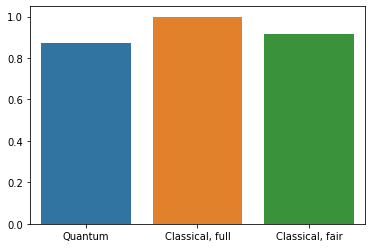

In [35]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])